In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height, channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
filename = 'cg-resnet50-init_weights.npy'
if os.path.exists(filename):
    print("Loading ResNet50 initial weights from %s ..." %(filename))
    init_weights = np.load(filename)
else:
    print("Generating ResNet50 initial weigths ...")
    init_weights = model.get_weights()
    print("Saving ResNet50 initial weights into %s ..." %(filename))
    np.save(filename, init_weights)

Loading ResNet50 initial weights from cg-resnet50-init_weights.npy ...


In [9]:
# Training the model from scratch
num_epochs=200
history = []
checkpointer = ModelCheckpoint(filepath='weights-cg-resnet50-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 7760 samples, validate on 1940 samples
Epoch 1/200
7760/7760 [==============================] - 103s - loss: 0.8985 - acc: 0.6345 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/200
7760/7760 [==============================] - 86s - loss: 0.6604 - acc: 0.6687 - val_loss: 0.7561 - val_acc: 0.5995
Epoch 3/200
7760/7760 [==============================] - 87s - loss: 0.5642 - acc: 0.7233 - val_loss: 0.6059 - val_acc: 0.6979
Epoch 4/200
7760/7760 [==============================] - 87s - loss: 0.5798 - acc: 0.7399 - val_loss: 0.5875 - val_acc: 0.7124
Epoch 5/200
7760/7760 [==============================] - 86s - loss: 0.5637 - acc: 0.7383 - val_loss: 0.8593 - val_acc: 0.6268
Epoch 6/200
7760/7760 [==============================] - 87s - loss: 0.5567 - acc: 0.7290 - val_loss: 0.9645 - val_acc: 0.6670
Epoch 7/200
7760/7760 [==============================] - 87s - loss: 0.5585 - acc: 0.7403 - val_loss: 1.1521 - val_acc: 0.7046
Epoch 8/200
7760/7760 [==============================] - 87s -

7760/7760 [==============================] - 86s - loss: 0.0410 - acc: 0.9860 - val_loss: 1.0732 - val_acc: 0.7825
Epoch 128/200
7760/7760 [==============================] - 86s - loss: 0.0142 - acc: 0.9945 - val_loss: 1.1866 - val_acc: 0.8093
Epoch 129/200
7760/7760 [==============================] - 86s - loss: 0.0122 - acc: 0.9964 - val_loss: 1.0926 - val_acc: 0.7948
Epoch 130/200
7760/7760 [==============================] - 86s - loss: 0.0146 - acc: 0.9957 - val_loss: 1.6638 - val_acc: 0.7649
Epoch 131/200
7760/7760 [==============================] - 86s - loss: 0.0104 - acc: 0.9968 - val_loss: 1.1406 - val_acc: 0.8041
Epoch 132/200
7760/7760 [==============================] - 86s - loss: 0.0081 - acc: 0.9972 - val_loss: 1.0973 - val_acc: 0.8144
Epoch 133/200
7760/7760 [==============================] - 86s - loss: 0.0095 - acc: 0.9972 - val_loss: 1.2608 - val_acc: 0.7907
Epoch 134/200
7760/7760 [==============================] - 86s - loss: 0.0497 - acc: 0.9840 - val_loss: 1.0757 

7760/7760 [==============================] - 86s - loss: 0.0632 - acc: 0.9768 - val_loss: 0.8885 - val_acc: 0.7794
Epoch 53/200
7760/7760 [==============================] - 86s - loss: 0.0677 - acc: 0.9751 - val_loss: 1.7181 - val_acc: 0.7294
Epoch 54/200
7760/7760 [==============================] - 86s - loss: 0.0673 - acc: 0.9771 - val_loss: 1.4128 - val_acc: 0.7438
Epoch 55/200
7760/7760 [==============================] - 86s - loss: 0.0676 - acc: 0.9755 - val_loss: 1.5612 - val_acc: 0.7072
Epoch 56/200
7760/7760 [==============================] - 86s - loss: 0.0528 - acc: 0.9811 - val_loss: 1.2123 - val_acc: 0.7706
Epoch 57/200
7760/7760 [==============================] - 86s - loss: 0.0541 - acc: 0.9800 - val_loss: 1.7125 - val_acc: 0.7010
Epoch 58/200
7760/7760 [==============================] - 86s - loss: 0.0509 - acc: 0.9798 - val_loss: 1.0420 - val_acc: 0.7871
Epoch 59/200
7760/7760 [==============================] - 87s - loss: 0.0508 - acc: 0.9809 - val_loss: 0.9043 - val_a

7760/7760 [==============================] - 86s - loss: 0.0180 - acc: 0.9929 - val_loss: 1.2610 - val_acc: 0.7825
Epoch 179/200
7760/7760 [==============================] - 86s - loss: 0.0127 - acc: 0.9959 - val_loss: 1.3250 - val_acc: 0.7861
Epoch 180/200
7760/7760 [==============================] - 86s - loss: 0.0111 - acc: 0.9959 - val_loss: 1.4694 - val_acc: 0.7629
Epoch 181/200
7760/7760 [==============================] - 87s - loss: 0.0070 - acc: 0.9977 - val_loss: 1.3879 - val_acc: 0.7851
Epoch 182/200
7760/7760 [==============================] - 86s - loss: 0.0288 - acc: 0.9888 - val_loss: 1.4115 - val_acc: 0.7381
Epoch 183/200
7760/7760 [==============================] - 86s - loss: 0.0082 - acc: 0.9966 - val_loss: 1.5239 - val_acc: 0.7799
Epoch 184/200
7760/7760 [==============================] - 86s - loss: 0.0066 - acc: 0.9974 - val_loss: 1.6865 - val_acc: 0.7474
Epoch 185/200
7760/7760 [==============================] - 86s - loss: 0.0133 - acc: 0.9959 - val_loss: 1.5819 

7760/7760 [==============================] - 86s - loss: 0.0311 - acc: 0.9897 - val_loss: 2.6991 - val_acc: 0.6881
Epoch 105/200
7760/7760 [==============================] - 87s - loss: 0.0355 - acc: 0.9880 - val_loss: 1.1744 - val_acc: 0.7840
Epoch 106/200
7760/7760 [==============================] - 86s - loss: 0.0306 - acc: 0.9893 - val_loss: 1.0979 - val_acc: 0.7897
Epoch 107/200
7760/7760 [==============================] - 86s - loss: 0.0637 - acc: 0.9780 - val_loss: 1.0591 - val_acc: 0.7696
Epoch 108/200
7760/7760 [==============================] - 87s - loss: 0.0140 - acc: 0.9957 - val_loss: 0.8808 - val_acc: 0.8216
Epoch 109/200
7760/7760 [==============================] - 86s - loss: 0.0059 - acc: 0.9983 - val_loss: 1.1445 - val_acc: 0.7933
Epoch 110/200
7760/7760 [==============================] - 86s - loss: 0.0118 - acc: 0.9968 - val_loss: 1.8226 - val_acc: 0.7521
Epoch 111/200
7760/7760 [==============================] - 87s - loss: 0.0499 - acc: 0.9835 - val_loss: 1.0317 

7760/7760 [==============================] - 86s - loss: 0.5220 - acc: 0.7838 - val_loss: 3.4841 - val_acc: 0.5856
Epoch 30/200
7760/7760 [==============================] - 86s - loss: 0.6056 - acc: 0.7110 - val_loss: 0.9100 - val_acc: 0.6448
Epoch 31/200
7760/7760 [==============================] - 86s - loss: 0.5541 - acc: 0.7271 - val_loss: 0.5560 - val_acc: 0.7175
Epoch 32/200
7760/7760 [==============================] - 86s - loss: 0.5262 - acc: 0.7463 - val_loss: 0.5165 - val_acc: 0.7381
Epoch 33/200
7760/7760 [==============================] - 87s - loss: 0.5210 - acc: 0.7454 - val_loss: 0.5312 - val_acc: 0.7335
Epoch 34/200
7760/7760 [==============================] - 86s - loss: 0.4961 - acc: 0.7633 - val_loss: 0.5882 - val_acc: 0.7562
Epoch 35/200
7760/7760 [==============================] - 86s - loss: 0.4814 - acc: 0.7723 - val_loss: 0.9268 - val_acc: 0.7242
Epoch 36/200
7760/7760 [==============================] - 87s - loss: 0.4673 - acc: 0.7820 - val_loss: 0.5954 - val_a

7760/7760 [==============================] - 86s - loss: 0.0447 - acc: 0.9832 - val_loss: 1.0328 - val_acc: 0.7773
Epoch 157/200
7760/7760 [==============================] - 86s - loss: 0.0138 - acc: 0.9951 - val_loss: 1.1068 - val_acc: 0.7928
Epoch 158/200
7760/7760 [==============================] - 86s - loss: 0.0086 - acc: 0.9974 - val_loss: 1.1146 - val_acc: 0.7969
Epoch 159/200
7760/7760 [==============================] - 86s - loss: 0.0151 - acc: 0.9952 - val_loss: 1.5572 - val_acc: 0.7485
Epoch 160/200
7760/7760 [==============================] - 86s - loss: 0.0140 - acc: 0.9951 - val_loss: 1.5750 - val_acc: 0.7438
Epoch 161/200
7760/7760 [==============================] - 86s - loss: 0.0085 - acc: 0.9972 - val_loss: 1.3928 - val_acc: 0.7670
Epoch 162/200
7760/7760 [==============================] - 86s - loss: 0.0088 - acc: 0.9969 - val_loss: 1.2975 - val_acc: 0.7840
Epoch 163/200
7760/7760 [==============================] - 86s - loss: 0.0056 - acc: 0.9982 - val_loss: 1.2639 

7760/7760 [==============================] - 86s - loss: 0.0566 - acc: 0.9796 - val_loss: 0.9503 - val_acc: 0.7928
Epoch 83/200
7760/7760 [==============================] - 87s - loss: 0.0544 - acc: 0.9795 - val_loss: 1.2103 - val_acc: 0.7634
Epoch 84/200
7760/7760 [==============================] - 86s - loss: 0.0412 - acc: 0.9844 - val_loss: 1.0280 - val_acc: 0.7706
Epoch 85/200
7760/7760 [==============================] - 86s - loss: 0.0346 - acc: 0.9865 - val_loss: 1.2723 - val_acc: 0.7500
Epoch 86/200
7760/7760 [==============================] - 86s - loss: 0.0489 - acc: 0.9836 - val_loss: 1.2516 - val_acc: 0.7753
Epoch 87/200
7760/7760 [==============================] - 86s - loss: 0.0340 - acc: 0.9881 - val_loss: 2.0664 - val_acc: 0.6969
Epoch 88/200
7760/7760 [==============================] - 86s - loss: 0.0406 - acc: 0.9865 - val_loss: 1.7779 - val_acc: 0.6933
Epoch 89/200
7760/7760 [==============================] - 86s - loss: 0.0671 - acc: 0.9776 - val_loss: 1.4850 - val_a

In [10]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.7585


In [11]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

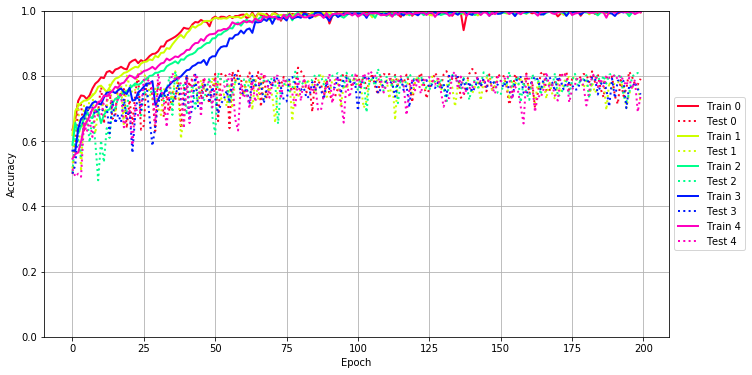

In [12]:
plot_acc(history)

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

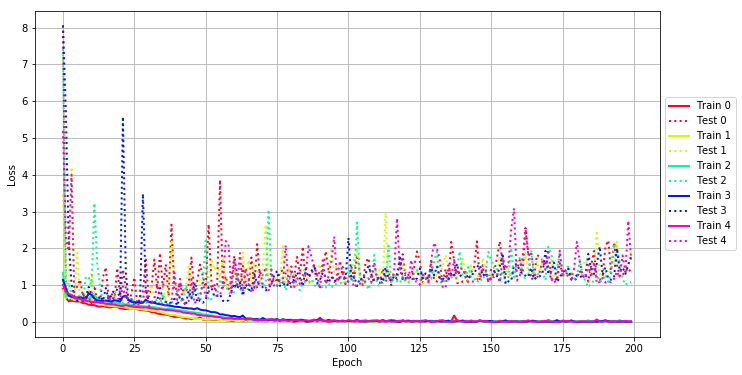

In [14]:
plot_loss(history)

Plotting the confusion matrix


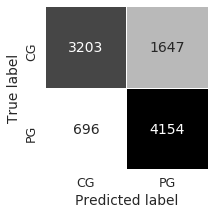

In [15]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


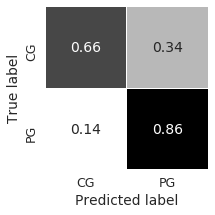

In [16]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'val_loss': [8.0590477552610569, 0.75607470556632761, 0.605852853883173, 0.58753604249855906, 0.8593452905871205, 0.96452428028755577, 1.1520803097597103, 0.69098168869608456, 0.75112684154018916, 0.79266864933918435, 0.51789605617523193, 0.98779731577204677, 0.54528563219247406, 0.55682619078872131, 1.2155214157301126, 1.4866686961085527, 0.62400890809973486, 0.77846286075631366, 0.57137779218634377, 1.4653911918708959, 0.73016090786334165, 1.4285297009133802, 0.92412887811660771, 0.47766314923148795, 0.78866394180612465, 1.2117246519044502, 0.50768784149405888, 0.55831299270551227, 0.83465874539208162, 1.6970807747742565, 0.68916102561754045, 0.94276038248514393, 1.698958101622837, 0.90268329369653133, 1.8756302898692101, 0.91115837256932997, 1.5658667584055477, 0.7152571187805884, 2.6447215237721955, 0.91375383375231756, 0.8297444591817168, 1.0450665862289901, 0.86627504334007344, 0.81605415252066149, 1.0230934986134166, 1.7531646942354968, 0.80825918728543311, 1.1095951888979096, 

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

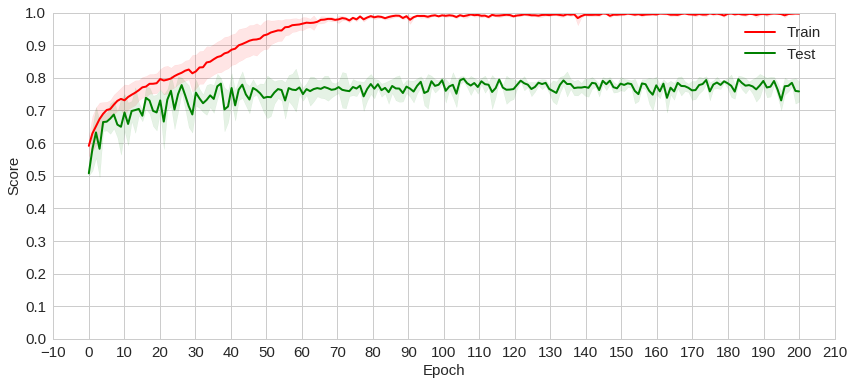

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

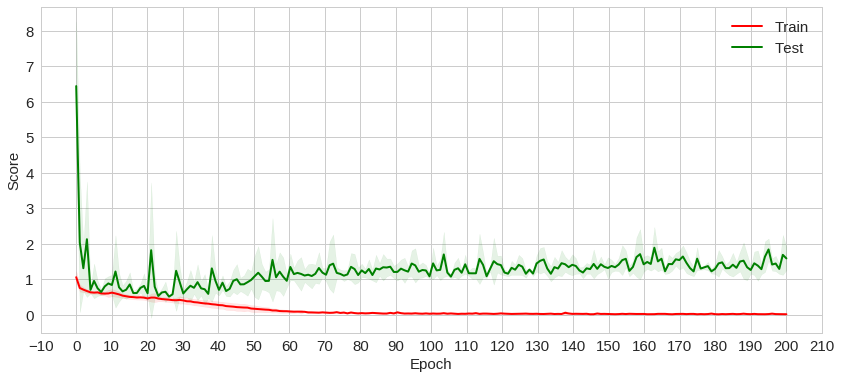

In [21]:
plot_mean_loss(history)

In [1]:
history = [{'val_loss': [8.0590477552610569, 0.75607470556632761, 0.605852853883173, 0.58753604249855906, 0.8593452905871205, 0.96452428028755577, 1.1520803097597103, 0.69098168869608456, 0.75112684154018916, 0.79266864933918435, 0.51789605617523193, 0.98779731577204677, 0.54528563219247406, 0.55682619078872131, 1.2155214157301126, 1.4866686961085527, 0.62400890809973486, 0.77846286075631366, 0.57137779218634377, 1.4653911918708959, 0.73016090786334165, 1.4285297009133802, 0.92412887811660771, 0.47766314923148795, 0.78866394180612465, 1.2117246519044502, 0.50768784149405888, 0.55831299270551227, 0.83465874539208162, 1.6970807747742565, 0.68916102561754045, 0.94276038248514393, 1.698958101622837, 0.90268329369653133, 1.8756302898692101, 0.91115837256932997, 1.5658667584055477, 0.7152571187805884, 2.6447215237721955, 0.91375383375231756, 0.8297444591817168, 1.0450665862289901, 0.86627504334007344, 0.81605415252066149, 1.0230934986134166, 1.7531646942354968, 0.80825918728543311, 1.1095951888979096, 1.5604324547593127, 1.2383686259849784, 0.95118850924305076, 2.6577071611414249, 1.0811430262536117, 0.87802032121677986, 1.0084173858780221, 3.8630389002795074, 0.93134910200060028, 1.2476812780517892, 0.89011577232596806, 1.1329713246257034, 1.7989917316387609, 1.2747132085033299, 0.97519784563595491, 1.5270659387726144, 1.0777048354296339, 1.0053778832720728, 1.7534174006009839, 0.92836397947724336, 2.1163203617961135, 1.2176700917715879, 1.2830181807279586, 1.4861339126665567, 1.1508110950902566, 1.0379264043778489, 1.2263867088199891, 1.0764099231700308, 1.3683976782965905, 1.404308774729365, 1.3200873999251532, 0.96450236064871564, 0.95390325182491975, 1.2454829343815439, 1.7706177138790642, 1.2911091131033356, 2.0473216976087119, 1.0635060838817321, 1.2481374858580914, 1.2700113033510976, 1.5472605115359592, 1.2578547364657686, 1.360639940094702, 1.386122619122574, 1.9243593166783912, 1.424716824600377, 1.3681379991708342, 1.0868273744878081, 1.1838412815762549, 1.1252049632908143, 1.4952597303488819, 1.0245168356551337, 1.1145112853689292, 1.4976722471492807, 1.1924430517806219, 1.8219047949486171, 1.3264910019550127, 1.0075298043870435, 1.6306560201743214, 1.7387505652363768, 1.1404874801635743, 1.1324515504935353, 1.1920253060527684, 1.0596936189022261, 1.4466674328464824, 1.1848107008589912, 1.405081300145572, 1.0005303609002496, 1.3312029547298077, 1.2924598246505581, 1.4283308284798848, 1.8429680927512573, 1.1452151018319672, 1.2826864331038956, 1.3095496728248204, 1.4842108569194361, 1.9176775145776492, 1.6591690763984759, 1.0731513460886848, 1.1865602149176844, 1.0926309369274021, 1.6638130207651669, 1.1406056288591366, 1.0973185288537408, 1.2608133559374466, 1.0757437622424253, 1.4373849239545999, 1.104852087473132, 2.1758823940434406, 1.6676408354769048, 1.0666155729097189, 1.0407831423061411, 1.1057203747562527, 1.1082802620130716, 1.1330250032169302, 1.3568956704483819, 1.4890369720065717, 2.192846926463019, 1.133814877087308, 1.5433585599525688, 1.2334683951643324, 1.1511652995630637, 1.4431164377743435, 1.374151999434245, 1.7388756683192301, 2.1906075364535615, 1.6050843556517178, 1.3029165100805538, 1.3348492806719749, 1.2618451796856123, 1.4369750312923155, 1.4239928019415471, 1.6846664552836075, 1.3365880568002917, 2.5564181837416493, 1.8853282216897944, 1.1596050242787783, 1.2006555277047699, 1.8219243968884971, 1.7696296267902729, 1.6896503001144252, 1.4173526488628585, 1.516908426383107, 1.123505001461383, 1.1981926647658201, 1.1186630976568792, 1.6149188913020891, 1.2836789367125205, 1.3041353815609646, 1.3657447365141406, 1.1564678160185666, 1.1154372237392307, 1.1902060127749885, 1.3906608163695975, 1.2463406562805175, 1.3068172420423056, 1.0972681507621844, 1.5473396440142209, 1.9314520363033432, 1.191842562390357, 1.1426946337690058, 1.2544220703164326, 2.0544358291576819, 2.2148411192844821, 1.3192965133902952, 2.1496707612706212, 1.5768297979512165, 1.2326177363543167, 1.277405270350348, 1.3807579975767235, 1.4683904126747367, 1.3357159594899601], 'acc': [0.63453608247422677, 0.66868556701030923, 0.72332474226804122, 0.73994845360824746, 0.7382731958762887, 0.72899484536082471, 0.74033505154639179, 0.76121134020618553, 0.77615979381443301, 0.78363402061855669, 0.79536082474226799, 0.79317010309278346, 0.81146907216494846, 0.8152061855670103, 0.80824742268041239, 0.81945876288659791, 0.82255154639175254, 0.8278350515463917, 0.82229381443298966, 0.8197164948453608, 0.83981958762886599, 0.84626288659793814, 0.84999999999999998, 0.83891752577319589, 0.84819587628865978, 0.84355670103092784, 0.85090206185567008, 0.86069587628865984, 0.86713917525773199, 0.86829896907216497, 0.87551546391752577, 0.89020618556701026, 0.89020618556701026, 0.90567010309278351, 0.91030927835051545, 0.91494845360824739, 0.92010309278350511, 0.92693298969072169, 0.93556701030927836, 0.94755154639175254, 0.94497422680412368, 0.94420103092783503, 0.95786082474226808, 0.96520618556701032, 0.96365979381443301, 0.97164948453608246, 0.96675257731958764, 0.96559278350515465, 0.95180412371134016, 0.97615979381443296, 0.98170103092783501, 0.97577319587628863, 0.98144329896907212, 0.98092783505154635, 0.97770618556701028, 0.98389175257731953, 0.97706185567010306, 0.98350515463917521, 0.98350515463917521, 0.98724226804123716, 0.98801546391752582, 0.97744845360824739, 0.98092783505154635, 0.99420103092783507, 0.97886597938144326, 0.99136597938144333, 0.98685567010309283, 0.98041237113402058, 0.99072164948453612, 0.97989690721649481, 0.98943298969072169, 0.99265463917525776, 0.98672680412371139, 0.96894329896907216, 0.98595360824742273, 0.98569587628865984, 0.98801546391752582, 0.9900773195876289, 0.98762886597938149, 0.98853092783505159, 0.99304123711340209, 0.99664948453608249, 0.99110824742268044, 0.98904639175257736, 0.98028350515463913, 0.99626288659793816, 0.99381443298969074, 0.98672680412371139, 0.98518041237113407, 0.99445876288659796, 0.96043814432989694, 0.98350515463917521, 0.99123711340206189, 0.99832474226804124, 0.99677835051546393, 0.98659793814432994, 0.9927835051546392, 0.9918814432989691, 0.99020618556701034, 0.99201030927835054, 0.9900773195876289, 0.99304123711340209, 0.99420103092783507, 0.9927835051546392, 0.99394329896907219, 0.990979381443299, 0.99523195876288661, 0.99703608247422681, 0.98981958762886602, 0.9954896907216495, 0.99394329896907219, 0.99523195876288661, 0.99239690721649487, 0.99471649484536084, 0.98853092783505159, 0.98079896907216491, 0.99613402061855671, 0.99871134020618557, 0.99896907216494846, 0.98427835051546386, 0.99484536082474229, 0.99432989690721651, 0.99742268041237114, 0.99716494845360826, 0.99626288659793816, 0.990979381443299, 0.98595360824742273, 0.99445876288659796, 0.9963917525773196, 0.99574742268041239, 0.99677835051546393, 0.99716494845360826, 0.99716494845360826, 0.98402061855670098, 0.99536082474226806, 0.99574742268041239, 0.99471649484536084, 0.94007731958762886, 0.98440721649484542, 0.99510309278350517, 0.99716494845360826, 0.99884020618556701, 0.99626288659793816, 0.99832474226804124, 0.99871134020618557, 0.99652061855670104, 0.99085051546391756, 0.9900773195876289, 0.99471649484536084, 0.99884020618556701, 0.9990979381443299, 0.99884020618556701, 0.99613402061855671, 0.99239690721649487, 0.99484536082474229, 0.99780927835051547, 0.9954896907216495, 0.99394329896907219, 0.9954896907216495, 0.99587628865979383, 0.99600515463917527, 0.99162371134020622, 0.99432989690721651, 0.99677835051546393, 0.99755154639175259, 0.9990979381443299, 0.99832474226804124, 0.9972938144329897, 0.99832474226804124, 0.99394329896907219, 0.98221649484536078, 0.990979381443299, 0.99664948453608249, 0.99793814432989691, 0.99832474226804124, 0.99935567010309279, 0.99935567010309279, 0.99922680412371134, 0.98427835051546386, 0.99626288659793816, 0.99896907216494846, 0.99974226804123711, 0.99768041237113403, 0.98981958762886602, 0.99175257731958766, 0.99780927835051547, 0.99561855670103094, 0.99304123711340209, 0.99832474226804124, 0.99845360824742269, 0.99845360824742269, 0.99123711340206189, 0.9954896907216495, 0.9963917525773196, 0.99523195876288661, 0.99871134020618557, 0.9954896907216495, 0.99896907216494846, 0.99845360824742269, 0.99432989690721651], 'loss': [0.89853520835797807, 0.66041792311619241, 0.56422068531980218, 0.57979431484163424, 0.56374615713493115, 0.55665843511365121, 0.55854762718849571, 0.51221430252507794, 0.50713130075906965, 0.47129430248565279, 0.46326802182443361, 0.45614248391279238, 0.42650660731128809, 0.41803936205573916, 0.43158809008057586, 0.41402131859789187, 0.39985852032592617, 0.39985378753278672, 0.41666540448198613, 0.40972653332444808, 0.37109897665141783, 0.36165744557823104, 0.34974207079287656, 0.36668753402749288, 0.36928236115839064, 0.37076036887070568, 0.34675602556503926, 0.32900516538275887, 0.32003085072507564, 0.31032155795195671, 0.30481297226296256, 0.26456173197510319, 0.26554547923127403, 0.23202048484812077, 0.21907421682298797, 0.20765562681193203, 0.20014532822923561, 0.18421231956826042, 0.16386635667577232, 0.13906299090877022, 0.13930074812210713, 0.14063305734973594, 0.10993097963714107, 0.094188390242070263, 0.10030156751115298, 0.075110708107960597, 0.093901268830618903, 0.089577731981719894, 0.12287408364264621, 0.066130203047056788, 0.052154426630970439, 0.063844711929751732, 0.055716721060657011, 0.051494234859866581, 0.060178336687386036, 0.044870738162822332, 0.070387215194167546, 0.045085692215595663, 0.044484912852766283, 0.034863679929031541, 0.032196731272047939, 0.062964244912733738, 0.057726467842447386, 0.017370837364230573, 0.063296426379496284, 0.025192096137163257, 0.037833121773719634, 0.06237980561023674, 0.028010056991149317, 0.055586968489068071, 0.029459089726286452, 0.021675851366173036, 0.03918791762025086, 0.088164779889522135, 0.04051481350325048, 0.041878617741167544, 0.033609836592732631, 0.027892608795142205, 0.035390397912064164, 0.034030794632649915, 0.020330450179765827, 0.0098825882617432203, 0.023626069572319747, 0.030256389346472994, 0.055649979459601887, 0.010795576909086523, 0.017795127410244811, 0.039863453058948374, 0.04082986807988323, 0.017332293847383759, 0.11620219078433422, 0.045203491069914142, 0.024381155622751002, 0.0078521537707912127, 0.009790514816035583, 0.039741655701973008, 0.020164282057799167, 0.025218112499827576, 0.025874426103552284, 0.020503180415955249, 0.029289502870968362, 0.022825693011706331, 0.018419456282107293, 0.018952173251207419, 0.019793960591418112, 0.028127517148650721, 0.013526843627074675, 0.0095947840869709967, 0.029495995971806271, 0.01478586850889488, 0.01699785518552388, 0.013679413640506797, 0.02178518193757123, 0.014599252759704615, 0.037710809441206534, 0.051511798956258625, 0.012374282745673254, 0.0039566095554769117, 0.0050991422966297851, 0.050903938982165275, 0.015306090252454748, 0.015146534479602441, 0.0087825646267372139, 0.0083266528035554864, 0.010885540609393202, 0.025776517849905204, 0.041000843205316398, 0.014227043957564712, 0.01223688200067026, 0.014584073504809886, 0.010370580613717843, 0.0080634990743194586, 0.009475938192827953, 0.049710348450108285, 0.014336830970696797, 0.013480434896419612, 0.01686462458515943, 0.17647659487484657, 0.044748471640818514, 0.017933746964968356, 0.011407210033617375, 0.0052194751691992504, 0.010488336551970486, 0.0044298409889380148, 0.0045699015004709168, 0.010548005524732307, 0.02717283181414085, 0.025693246591044109, 0.015072105576634676, 0.004055072037237888, 0.0031625548209010903, 0.0034794403184727363, 0.011293507691385157, 0.021261553121634674, 0.015947255717059981, 0.0073447154909876394, 0.012740918775431129, 0.016818623474052597, 0.015073535950211136, 0.012139584604901568, 0.011257868576323051, 0.024801332066939741, 0.016540591108442294, 0.0081955490606766771, 0.0072380536781940803, 0.0035558014869014553, 0.0056984916257374375, 0.0072075504562085415, 0.0042681964693234552, 0.019317991298637784, 0.050633017024140539, 0.023061403740178218, 0.010409620380600358, 0.0052970335126035972, 0.0044616309579368204, 0.0020442206610467336, 0.0020664727837487891, 0.0022875943186759801, 0.045984807825940131, 0.010563296054912366, 0.0030308495028293692, 0.0013568869044976646, 0.0055284357716952875, 0.029715936070250481, 0.022450632115312345, 0.0055892099981609076, 0.01499882551340972, 0.020709337399595601, 0.0055905703748648349, 0.00407148731679514, 0.0047702175125356079, 0.026089057403426982, 0.015437953633174645, 0.010018807969034467, 0.013918861656896193, 0.0047663361431800368, 0.012297188323777236, 0.0032753829224414395, 0.0048161324130409616, 0.016944818165331488], 'val_acc': [0.5, 0.59948453620537046, 0.69793814451424119, 0.71237113402061858, 0.6268041237113402, 0.66701030940124673, 0.70463917550352428, 0.69845360861611117, 0.69020618532121791, 0.69123711364785423, 0.77268041212534166, 0.65360824729978428, 0.7221649483307121, 0.7520618554243107, 0.66855670103092779, 0.6788659794428914, 0.78608247410390797, 0.73762886597938149, 0.75979381467878204, 0.63969072164948448, 0.72577319612208102, 0.65360824754557656, 0.74587628841400144, 0.80670103080493882, 0.63505154614596027, 0.64793814420700069, 0.79948453632826655, 0.78247422668122757, 0.73917525797775108, 0.63092783508227046, 0.782989691090338, 0.75000000006144807, 0.67422680400081514, 0.73969072171093264, 0.69175257744248375, 0.75000000012289614, 0.72371134045197794, 0.8015463918754735, 0.63969072164948448, 0.75721649459956852, 0.80103092783505159, 0.76649484560661707, 0.79484536057894994, 0.80618556713320544, 0.77886597950433945, 0.73556701055507068, 0.79484536119343074, 0.73969072140369219, 0.71597938119750659, 0.75463917525773194, 0.80618556676451691, 0.66134020621629108, 0.80515463892946537, 0.80721649496825698, 0.79690721661774155, 0.63969072168020857, 0.81340206197856624, 0.78144329921486455, 0.81597938181198748, 0.79175257756537998, 0.74329896882637259, 0.78814433026559572, 0.81030927835051547, 0.75618556707175733, 0.78144329872327978, 0.81237113402061856, 0.70515463942105006, 0.80515463917525776, 0.73092783499009828, 0.76494845336245509, 0.77938144317607294, 0.78247422668122757, 0.78505154663754495, 0.77216494820781589, 0.79690721686353394, 0.77422680436950364, 0.77164948453608251, 0.75360824717688801, 0.76701030952414284, 0.82525773245034761, 0.81494845360824741, 0.80000000036868857, 0.74948453620537037, 0.76907216507134979, 0.68969072152658839, 0.7943298970301127, 0.78092783554313105, 0.7778350516692879, 0.73195876300949414, 0.78762886622517381, 0.74432989678432027, 0.72371134008328941, 0.73711340206185572, 0.76237113377482624, 0.78969072177238075, 0.80670103117362735, 0.79896907265653316, 0.79072164973032844, 0.76546391752577314, 0.80051546404042195, 0.80000000049158471, 0.77319587604286744, 0.79948453620537041, 0.75773195863999043, 0.77989690721649485, 0.80670103117362735, 0.76804123723629825, 0.74278350490884681, 0.8030927838738432, 0.80567010346147205, 0.80206185567010313, 0.80567010309278353, 0.77268041212534166, 0.80309278399673933, 0.77164948465897865, 0.79175257768827612, 0.77783505179218415, 0.80360824742268044, 0.77783505154639176, 0.71907216488700554, 0.78814433026559572, 0.78969072189527689, 0.80927835100704859, 0.78144329896907216, 0.73092783480575407, 0.76237113414351476, 0.78247422729570837, 0.80927835088415245, 0.79484536107053461, 0.76494845373114362, 0.80412371134020622, 0.81443298969072164, 0.7907216496074323, 0.79072164985322457, 0.78659793814432988, 0.80154639150678497, 0.73298969078309761, 0.7381443300198034, 0.77886597913565092, 0.80670103105073121, 0.82113402061855667, 0.81391752589609201, 0.78453608296581145, 0.76701030915545432, 0.79226804160580189, 0.75257731958762886, 0.80463917550352426, 0.75412371146310231, 0.77731958775176213, 0.80567010321567967, 0.79690721698643008, 0.79948453608247427, 0.7695876291117717, 0.71185567034888508, 0.74536082449647567, 0.80515463917525776, 0.78608247447259649, 0.79278350490884686, 0.77113402074145287, 0.80721649496825698, 0.74587628841400144, 0.78350515439338286, 0.70154639175257727, 0.74845360812452655, 0.80721649509115312, 0.81237113426641094, 0.75360824754557654, 0.75257731934183647, 0.77938144354476147, 0.78041237113402062, 0.77938144329896908, 0.80979381480167822, 0.79639175306890431, 0.81288659806104047, 0.7577319585170943, 0.79020618581280266, 0.79329896956374968, 0.78711340181606337, 0.79690721674063769, 0.80567010346147205, 0.80360824779136897, 0.78092783517444253, 0.81391752626478053, 0.7814432990919683, 0.80567010321567967, 0.76030927859630781, 0.73453608247422686, 0.79278350540043152, 0.79742268053526733, 0.79742268053526733, 0.7376288657335891, 0.71340206160987774, 0.78711340206185565, 0.73814432989690726, 0.76134020606267083, 0.81288659793814433, 0.79742268078105971, 0.77371134045197787, 0.7731958765344521, 0.79123711364785421]}, 
{'val_loss': [3.4662591146439623, 0.64204109747385241, 0.70072341549027828, 4.2101178365884371, 0.71340285269255488, 1.8883281142441268, 0.57938293353798465, 0.5580794287711075, 0.72247382239582614, 0.80947462400210268, 1.329376660179846, 0.64090821985731417, 0.61216212928909619, 0.50272754123530439, 0.58592259247892908, 0.66246150117559532, 0.54522727224015699, 0.48956623206433564, 0.88213198241806523, 0.45382406699288752, 0.52430900439773642, 0.58058209038272346, 0.5407890455931732, 0.42973898901152857, 0.44062157144251557, 0.47582126989499812, 0.5000655635116027, 0.67473562808380916, 0.69647628169545195, 0.561254913044959, 0.76091190783940643, 1.0121884785822985, 0.64754533869089537, 0.64675206953717257, 0.65750289639246828, 0.98086131282688416, 0.53161753028938452, 0.73433473262282989, 2.2358843292215282, 1.3552168307384265, 0.7244984615555744, 0.94433566454759577, 0.79472886820122135, 0.88119076379795669, 1.5024075168924234, 0.79427475354720634, 0.97181042967383391, 1.128755028960631, 1.1187084253608566, 0.94429657439288406, 0.94841456579178884, 0.88850847645518705, 1.7180930523528266, 1.4128429395636333, 1.5612078687392137, 1.2123397422820021, 1.7124510570285247, 1.0419633837320756, 0.90425731601174342, 1.229599241205712, 1.3368801393152512, 1.2357774253973026, 1.0387993206682893, 1.8857167497814931, 0.95852489572824895, 1.6818394970648067, 1.0885417157841712, 1.5823051782689759, 1.4727494689607128, 1.1084602112929847, 1.3962873498189081, 2.649664098509712, 1.206773583824295, 1.0824625369314989, 1.2148312272023909, 1.0677937274241878, 1.0898187992839892, 2.0619167293469931, 1.0701893266175211, 1.527393413404214, 1.2712677696047676, 1.3239061176162406, 1.0861127275935154, 1.2051936676821757, 1.1401480601313188, 1.4975228218688179, 1.0699833071108946, 1.0427944044016071, 1.1440730996967592, 1.4378643803144853, 1.5754384389704035, 1.1535988839016746, 1.1093415175900632, 1.2917785322236031, 2.0123608604527186, 1.3675351973200582, 1.5539939429649372, 1.2295578680702091, 1.0841047593920501, 1.0995461857042361, 1.2083574512032504, 1.2625469124040654, 1.8018136140919223, 1.9387576688196242, 1.1764300527031888, 1.0220579962822196, 1.1930745027114436, 1.1970576914315372, 1.2464608356356621, 1.3649568114084067, 1.2533410120294572, 1.4352500521030622, 1.0419134306538966, 2.9605532468832685, 1.0979068568072368, 1.1407202984331195, 1.1566436030201077, 1.1209961759060929, 1.4118185824954632, 1.5533950031540578, 1.1789354799949017, 1.0947660106359069, 1.2369625119818854, 1.2980479240628708, 1.3864878361987085, 1.1293284384687383, 0.97488061539905591, 1.2748659080528106, 1.1800227001155774, 1.1757806478087436, 1.3591430929134187, 1.252666596393341, 1.2575114259774769, 1.5491211823581421, 1.8204101469098908, 1.5130443464849412, 1.2949746662808448, 1.256859990892951, 1.1964176488291356, 1.361918761926828, 1.7419542189725896, 1.3142442152672207, 1.0513601609112062, 1.5434146760665264, 1.3218354141589292, 1.2179408842755348, 1.2773911680142904, 1.7429626486965062, 1.3741478140974783, 1.2260438960237601, 1.3388710469007492, 1.218116881060846, 1.2787958441014142, 1.7881353674139635, 1.2190727955287264, 1.296172088261732, 1.4728332139167588, 1.1835133779601952, 1.2764565010660702, 1.2438322915244349, 1.3428174406290054, 1.5041003985349666, 1.885798599292553, 1.3143394244085882, 1.3706612385857428, 1.280076541667132, 1.6499746208722443, 1.3463809305782786, 1.7315316915512085, 1.6537668234601464, 1.348545580303546, 1.7267473835306069, 1.2065166037414492, 1.3308390136232082, 1.2169842361021288, 1.2916131796257704, 1.264826739479586, 1.2610246317288309, 1.3249779558673347, 1.469428430328664, 1.3878690183777169, 1.4115047994962673, 1.5239411511372045, 1.6864738862539075, 1.5818990126098553, 1.3295043455571243, 1.4784905909262982, 2.4844715071774868, 1.2818331875751927, 1.434533609250157, 1.3148519004435884, 1.3122771774985127, 1.4791025551132013, 1.5075882305803987, 2.1807406592461254, 1.6014659936895075, 1.4434954655539129, 1.3629074247227502, 1.5556161564649995, 2.0209912987421124], 'acc': [0.61842783505154642, 0.69278350515463916, 0.70747422680412375, 0.71688144329896908, 0.72396907216494844, 0.72487113402061853, 0.73054123711340202, 0.73969072164948457, 0.74858247422680413, 0.76662371134020624, 0.77010309278350519, 0.76043814432989687, 0.75025773195876289, 0.76456185567010304, 0.78041237113402062, 0.79175257731958759, 0.79471649484536078, 0.80090206185567014, 0.80914948453608249, 0.81134020618556701, 0.8170103092783505, 0.82293814432989687, 0.82770618556701026, 0.82590206185567006, 0.83775773195876291, 0.84265463917525774, 0.84381443298969072, 0.85038659793814431, 0.84819587628865978, 0.86134020618556706, 0.85708762886597933, 0.87036082474226806, 0.87152061855670104, 0.88505154639175254, 0.88286082474226801, 0.89652061855670107, 0.90721649484536082, 0.91817010309278346, 0.92538659793814437, 0.91649484536082471, 0.93092783505154642, 0.93917525773195876, 0.95270618556701026, 0.94768041237113398, 0.95463917525773201, 0.95837628865979385, 0.96778350515463918, 0.96855670103092784, 0.96817010309278351, 0.97203608247422679, 0.97847938144329893, 0.97680412371134018, 0.97512886597938142, 0.97706185567010306, 0.97551546391752575, 0.98105670103092779, 0.98002577319587625, 0.97976804123711336, 0.98092783505154635, 0.97693298969072162, 0.98182989690721645, 0.99085051546391756, 0.98144329896907212, 0.99033505154639179, 0.97203608247422679, 0.99072164948453612, 0.99123711340206189, 0.98930412371134024, 0.98505154639175263, 0.97100515463917525, 0.99123711340206189, 0.98994845360824746, 0.98414948453608242, 0.98685567010309283, 0.98634020618556706, 0.97963917525773192, 0.99304123711340209, 0.98389175257731953, 0.98943298969072169, 0.99213917525773199, 0.99175257731958766, 0.98865979381443303, 0.98530927835051552, 0.98543814432989696, 0.99626288659793816, 0.98118556701030923, 0.98543814432989696, 0.99613402061855671, 0.99123711340206189, 0.99136597938144333, 0.99536082474226806, 0.99020618556701034, 0.9873711340206186, 0.98969072164948457, 0.99226804123711343, 0.99381443298969074, 0.99046391752577323, 0.99265463917525776, 0.98762886597938149, 0.99420103092783507, 0.99536082474226806, 0.99690721649484537, 0.98724226804123716, 0.98775773195876293, 0.99201030927835054, 0.97951030927835048, 0.99600515463917527, 0.99626288659793816, 0.9972938144329897, 0.99845360824742269, 0.99793814432989691, 0.98530927835051552, 0.9846649484536083, 0.99510309278350517, 0.99471649484536084, 0.9945876288659794, 0.99226804123711343, 0.9873711340206186, 0.98904639175257736, 0.9891752577319588, 0.98904639175257736, 0.99742268041237114, 0.99201030927835054, 0.99845360824742269, 0.99600515463917527, 0.98672680412371139, 0.9855670103092784, 0.9972938144329897, 0.99742268041237114, 0.98943298969072169, 0.99329896907216497, 0.99832474226804124, 0.99871134020618557, 0.99445876288659796, 0.99329896907216497, 0.99523195876288661, 0.99690721649484537, 0.98840206185567014, 0.99239690721649487, 0.9963917525773196, 0.99600515463917527, 0.99085051546391756, 0.98518041237113407, 0.99445876288659796, 0.9990979381443299, 0.9990979381443299, 0.99922680412371134, 0.99613402061855671, 0.99110824742268044, 0.99523195876288661, 0.9918814432989691, 0.99523195876288661, 0.99123711340206189, 0.990979381443299, 0.99613402061855671, 0.99407216494845363, 0.99149484536082477, 0.99600515463917527, 0.99587628865979383, 0.99033505154639179, 0.99664948453608249, 0.99935567010309279, 0.99858247422680413, 0.99806701030927836, 0.99291237113402064, 0.99432989690721651, 0.9954896907216495, 0.99703608247422681, 0.99355670103092786, 0.99381443298969074, 0.99626288659793816, 0.99793814432989691, 0.98685567010309283, 0.99664948453608249, 0.99845360824742269, 0.99961340206185567, 0.99922680412371134, 0.99291237113402064, 0.99587628865979383, 0.99587628865979383, 0.99768041237113403, 0.98878865979381447, 0.99664948453608249, 0.99742268041237114, 0.99587628865979383, 0.99613402061855671, 0.99394329896907219, 0.99574742268041239, 0.98994845360824746, 0.9963917525773196, 0.99832474226804124, 0.99922680412371134, 0.99896907216494846, 0.99832474226804124, 0.99574742268041239, 0.9855670103092784, 0.99768041237113403, 0.99716494845360826, 0.99896907216494846, 0.99806701030927836], 'loss': [0.86544635418764093, 0.65352608567660619, 0.72806136632703011, 0.63748912344273834, 0.59624175066800467, 0.60119780302047732, 0.59026300317233371, 0.57132595845104495, 0.56946610095574679, 0.53105332753092971, 0.62330942768411535, 0.612340784810253, 0.62755809782706584, 0.52309947136751156, 0.46563300422786436, 0.45071304815331686, 0.44257700246633941, 0.43568119357541663, 0.42195230808454692, 0.42380594592733484, 0.40587019637687921, 0.40425172319117281, 0.38900302034063439, 0.38650253562583137, 0.37048842882372668, 0.35758058189116804, 0.35902420872265528, 0.34534518663416203, 0.34032931966879931, 0.32576190245520209, 0.32943047580030776, 0.30582677531488162, 0.3019269284513808, 0.2866539225750363, 0.27625274400121158, 0.25050717960927904, 0.22814398979403308, 0.2037677341515256, 0.18927986345340297, 0.19841169398470024, 0.1685578056371089, 0.15368688638062822, 0.12567873130139617, 0.13266121032311745, 0.12099000533524248, 0.10890279507514128, 0.0844342628090652, 0.080593803740039313, 0.082878605191855081, 0.078164104022776959, 0.062772340411032287, 0.063163089706111203, 0.067687566340276881, 0.067280219710364783, 0.0676170707824304, 0.052760445672212185, 0.054072084370040401, 0.050940764491859171, 0.050790863906599815, 0.061854586875085361, 0.049743841788203444, 0.025794653731791937, 0.051815351623004859, 0.029155812172948853, 0.077070436004510856, 0.029460916173711573, 0.023925499486996186, 0.030141170639496718, 0.040831359843579454, 0.0799786264441677, 0.024196747295347223, 0.030789190787970828, 0.045463697664132441, 0.03561191188901202, 0.039892800087973322, 0.052970987913611621, 0.020433075287734571, 0.046872204173471509, 0.028927243267637244, 0.026511009112864581, 0.021575483650007506, 0.029218548053837161, 0.043491004514940007, 0.041754010464688858, 0.014257398357173217, 0.051849933779923266, 0.044737811448993449, 0.01115844161969792, 0.023986484128597777, 0.027864429077191145, 0.014620642290815481, 0.026670103596725031, 0.033295439438145495, 0.027081003308430621, 0.021734253952241281, 0.018119621502005103, 0.027145129061044798, 0.021116823733294595, 0.035787647526672822, 0.015688898507985719, 0.01377492077605434, 0.010320798824445258, 0.032875999383935608, 0.034037529195169197, 0.025026442305444135, 0.055816846038454895, 0.010389924218239666, 0.01149937831988731, 0.010764628558386041, 0.0053022449949549841, 0.0058619315946623488, 0.042074166619478118, 0.046089790964057457, 0.016224288421001324, 0.017004203456021921, 0.017342656574928509, 0.022252695641441982, 0.033626567653005889, 0.031164794947145524, 0.027781543426561296, 0.032878729230100191, 0.0092693881798996455, 0.024686552719069048, 0.0069701055087600401, 0.011226518467889581, 0.036029859548482625, 0.041540172250134892, 0.0073619141459426623, 0.0080812340297438581, 0.029456447932350728, 0.017133782506853188, 0.0044773352385220145, 0.0042210088766446415, 0.013804604776429263, 0.01959161838221354, 0.012231200534808953, 0.0092744893151978699, 0.030780703111158051, 0.021789685447433888, 0.008747504610096022, 0.012770122772241108, 0.025520518339915949, 0.040765676441477591, 0.017641193314981117, 0.0038240676190099228, 0.0028173299614320866, 0.0027865925926046646, 0.0085631365976032332, 0.024187731422716751, 0.012032650408248618, 0.020563818333603288, 0.013699462683140042, 0.023557145797801157, 0.02874650815681833, 0.010051825560014887, 0.014953395211889131, 0.026842193288090111, 0.012365061240318741, 0.012017327041806865, 0.02726441414813156, 0.010120258671615619, 0.0024956220231671846, 0.0036249390269957301, 0.0063815797672525394, 0.020777274060096669, 0.015630994343496477, 0.013501657604134267, 0.0082346477471388034, 0.019941676048845169, 0.018228787946822027, 0.0091525872045655054, 0.0068771217753162573, 0.038049290221683761, 0.01055984145628058, 0.0048550404371218471, 0.0020709988777075665, 0.0025760162029908633, 0.018014357686276815, 0.012682456130368308, 0.011125476789941588, 0.0070139372962546177, 0.028775022773206541, 0.0081834105939781968, 0.0065821981071626538, 0.013264978264900135, 0.0092114024106701164, 0.015104509550884855, 0.013067792288235331, 0.029034433241443919, 0.0094626130600407067, 0.0060840852581415823, 0.0028116693874741857, 0.0033470424554027504, 0.0047995013450905467, 0.013398570036389577, 0.045808771292897441, 0.0077283417792827578, 0.0072615903101323808, 0.0032793027038875602, 0.0048051798431299978], 'val_acc': [0.51649484511503241, 0.68041237125691678, 0.72061855670103092, 0.5077319585170943, 0.70876288708952284, 0.64742268065816344, 0.73556701080086306, 0.74329896919506111, 0.6231958762886598, 0.70051546391752573, 0.72783505154639172, 0.68711340206185567, 0.69948453657405896, 0.77319587604286744, 0.70824742255751616, 0.68608247422680413, 0.75773195888578282, 0.77835051570970992, 0.64690721649484539, 0.80051546416331809, 0.7695876291117717, 0.74793814482148158, 0.75773195876288657, 0.80927835051546393, 0.81391752577319587, 0.80206185567010313, 0.79896907241074078, 0.74432989739880118, 0.72835051546391749, 0.76082474202224892, 0.7010309278350515, 0.67989690721649487, 0.75773195876288657, 0.76804123723629825, 0.75360824717688801, 0.71907216519424599, 0.81391752565029973, 0.75773195876288657, 0.60773195876288655, 0.68041237113402064, 0.77061855670103097, 0.74639175270021574, 0.75876288659793811, 0.78144329921486455, 0.71546391752577321, 0.78711340206185565, 0.75979381418719738, 0.7644329896907216, 0.74639175245442346, 0.79381443298969068, 0.76443298993651398, 0.77938144317607294, 0.72938144342186528, 0.74381443348127541, 0.70721649484536087, 0.77061855670103097, 0.7010309278350515, 0.78711340206185565, 0.78608247410390797, 0.74381443286679449, 0.74175257731958766, 0.78350515451627911, 0.78556701006348595, 0.69536082474226801, 0.79484536070184608, 0.72628866028539918, 0.79432989666142417, 0.72835051546391749, 0.74896907241074084, 0.76494845348535123, 0.73865979356864064, 0.65567010309278351, 0.77835051546391754, 0.76546391752577314, 0.77268041237113405, 0.77268041237113405, 0.78402061855670102, 0.66185567010309276, 0.77061855670103097, 0.73350515463917521, 0.76546391752577314, 0.76649484548372093, 0.78711340193895951, 0.78092783480575401, 0.77371134008328935, 0.74845360837031882, 0.78298969059875334, 0.80670103080493882, 0.79432989678432031, 0.7355670103092784, 0.74072164936163987, 0.78814432977401105, 0.78711340193895951, 0.77422680412371137, 0.70463917525773201, 0.77268041212534166, 0.75979381431009352, 0.7855670101863822, 0.78350515463917525, 0.79484536082474222, 0.77525773195876291, 0.7690721648255574, 0.7020618555472069, 0.72319587641155592, 0.79226804099132109, 0.78865979381443296, 0.7891752576090626, 0.78350515488496764, 0.77319587616576357, 0.77680412346554784, 0.79123711340206182, 0.7304123708882283, 0.79381443286679454, 0.66443298969072162, 0.79278350527753538, 0.79845360812452648, 0.77938144317607294, 0.77783505142349563, 0.77474226779544475, 0.73969072164948457, 0.78247422655833132, 0.79690721674063769, 0.77731958750596986, 0.76597938144329902, 0.75721649509115319, 0.78195876288659794, 0.79793814420700071, 0.77731958750596986, 0.78711340193895951, 0.76134020593977469, 0.75257731958762886, 0.77010309278350519, 0.78195876288659794, 0.76494845385403976, 0.70618556676451694, 0.77164948478187478, 0.78350515463917525, 0.78762886585648528, 0.78865979369153683, 0.78350515451627911, 0.74587628865979383, 0.7670103094012467, 0.77989690709359871, 0.72474226779544482, 0.7819587633781826, 0.79329896882637263, 0.79742268065816346, 0.75618556701030926, 0.77113402049566049, 0.78814432965111492, 0.78402061843380488, 0.79072164923874377, 0.77680412358844408, 0.72783505154639172, 0.78453608235133065, 0.77938144317607294, 0.76907216519424593, 0.78917525748616646, 0.78814432989690719, 0.78350515463917525, 0.76340206173277392, 0.76340206173277392, 0.71649484536082475, 0.77938144354476147, 0.75515463917525771, 0.78041237137981301, 0.72989690721649481, 0.78350515451627911, 0.7463917525773196, 0.72886597938144326, 0.77525773183586666, 0.75051546416331816, 0.78041237088822824, 0.79175257744248384, 0.79690721637194917, 0.79226804123711336, 0.79793814420700071, 0.78247422704991609, 0.78608247422680411, 0.76288659769235201, 0.78505154639175256, 0.73814432965111487, 0.77989690770807951, 0.74742268090395581, 0.76494845373114362, 0.78659793802143374, 0.78298969096744186, 0.69536082474226801, 0.7814432990919683, 0.76082474251383359, 0.77989690746228724, 0.78195876313239032, 0.77113402061855674, 0.77577319612208095, 0.70154639175257727, 0.74639175306890426, 0.7623711342664109, 0.77474226779544475, 0.76855670115382402, 0.71907216494845361]}, 
{'val_loss': [7.4177227003979933, 0.69166328612062122, 1.0830810399399591, 0.77236705612890499, 0.60376755048319242, 0.62287778743763556, 0.7601625177049145, 0.58952574459547846, 1.2323846084555399, 1.2187819461232607, 0.94991880513958094, 3.2326547119420828, 1.5684606365321838, 0.9569365889755721, 0.55504871963225688, 0.59681166471894254, 0.53335215799587288, 0.53785153688843712, 0.64420766928761275, 0.5976964080456606, 0.51884781945612013, 0.51088247581855539, 0.48961001118433845, 0.49631097058659979, 0.66732185037480185, 0.50851427476430677, 0.5472381501314566, 0.53487189246207167, 0.53000310432050646, 0.51569645908689987, 0.53341747860318611, 0.55585100951882982, 0.54951164802325136, 0.61938927738936911, 0.48233848625851661, 0.77165524486413939, 0.45928450017860256, 0.50337638609188118, 0.53996923313927403, 0.54475739343264673, 0.87616448277204306, 0.61718480365792505, 0.53067466387736428, 0.99034090165010435, 0.80176647717190774, 0.62110356399693445, 0.90977726425092242, 0.89741562666352259, 0.55423549647183767, 1.0926707350024858, 2.2134006549402612, 0.58191186619788104, 0.62710744984371147, 0.70838490577088187, 0.74238507059431569, 1.1661320885432136, 0.9865272502309268, 0.99810849188529338, 0.81489091116128509, 0.75657157689025722, 0.81088591909285668, 1.3379825179109868, 0.91271642213015214, 0.77078098107859028, 0.97185902964208548, 0.87615396143081259, 0.95360631537191642, 0.98788029840312053, 0.97570465594222866, 1.1378672365060787, 0.9731382324523532, 1.0115796465695519, 3.0545576684253732, 1.2825934945922537, 1.0586543995848636, 0.9740696724235397, 1.0614067421899629, 1.2156503662620624, 0.85982849296835284, 1.0763923154049313, 1.3534364980520661, 1.179449708928767, 0.9957551802556539, 0.86037751743473956, 1.0511156064947855, 1.093390643473753, 1.0612767512036354, 1.1626477373936741, 0.99979961164218867, 0.95517804009705476, 1.0382149386037256, 0.90657100726648709, 0.9369861906336755, 1.0387642585125165, 0.92832762347054232, 1.0374741451641949, 1.0142772885941969, 1.0469498206506069, 1.092784438796879, 1.0613341152667999, 1.4794787975930677, 1.1022560539933823, 1.125108855778409, 2.6990639776605923, 1.1744360645599279, 1.0979094697028091, 1.059059860780067, 0.88077648663029229, 1.1445462698788986, 1.8226158395736027, 1.031658465253938, 0.97806512572101711, 1.1659538805638392, 1.1109950306489296, 2.0739054399667327, 1.0359844030793179, 1.328851361311588, 1.115843122767419, 1.054993545517479, 1.2486361375789052, 1.0755247755148976, 1.0822741287270772, 1.0967191143134205, 1.3345800844664426, 1.4030885720683128, 1.4933784037521205, 1.2287460500432044, 1.303290050426863, 1.2684378120088087, 1.1789330100275806, 1.6516450401433964, 1.9135802259246253, 1.1007837427031133, 1.041936735639867, 1.2142647079585753, 1.1738570421626888, 1.2183715665616941, 1.2099829727841407, 1.5237879649880006, 1.9251540032282626, 1.2159806219572873, 1.2113779382607373, 1.4961280203357186, 1.2077643200294259, 1.190556177404738, 1.0729163421797998, 1.1754104901834861, 1.1197489028124465, 1.3299702091776218, 1.9049988427113012, 1.6667003503779776, 1.464083743832775, 1.4855736961549859, 1.1034336969717262, 1.3992468170283996, 1.0746783485117646, 1.2267697027663595, 2.0147424066189639, 1.1496103856981414, 1.7110819752683344, 1.7360262510354736, 1.2334663071583227, 1.1943653010215955, 1.2698789215579476, 1.9579312465556888, 1.1247039386906574, 1.2356987845037402, 1.3782370121976764, 1.3374883436050611, 1.1323041008919785, 2.0464533058638423, 1.8656617498889412, 1.4327256665248231, 1.4239990140973908, 1.908482620396565, 1.2742038983045165, 1.2908573159237497, 1.5367083904669456, 1.2576185541054636, 1.1836787525372408, 1.1776925976743404, 1.6874917862264767, 1.2560029728818185, 1.1166540509032219, 0.94345594263568366, 1.0608409529494256, 1.1182860443272542, 1.2716433724484493, 1.0977354467529612, 1.1193487277964955, 1.290132369454374, 1.0866015817701202, 1.364544749505741, 2.1351599327067738, 2.0406851960211685, 1.6142641475520183, 1.1763825190435979, 1.0084060938087935, 1.0774697452476345, 1.0883439594937354], 'acc': [0.58853092783505156, 0.65605670103092784, 0.62358247422680413, 0.64510309278350519, 0.66804123711340202, 0.68969072164948453, 0.67293814432989696, 0.67203608247422686, 0.69626288659793811, 0.6929123711340206, 0.65515463917525774, 0.67989690721649487, 0.69342783505154637, 0.69768041237113398, 0.71585051546391754, 0.72963917525773192, 0.72912371134020615, 0.74213917525773199, 0.74922680412371134, 0.75219072164948453, 0.76069587628865976, 0.76855670103092788, 0.77719072164948455, 0.77255154639175261, 0.77757731958762888, 0.78737113402061853, 0.78981958762886595, 0.80000000000000004, 0.80115979381443303, 0.80940721649484537, 0.8097938144329897, 0.81481958762886597, 0.81572164948453607, 0.82912371134020624, 0.83479381443298972, 0.83891752577319589, 0.84458762886597938, 0.83814432989690724, 0.85064432989690719, 0.84948453608247421, 0.85953608247422686, 0.86456185567010313, 0.86701030927835054, 0.87255154639175259, 0.88337628865979378, 0.88634020618556697, 0.89407216494845365, 0.90025773195876291, 0.90154639175257734, 0.91456185567010306, 0.91572164948453605, 0.92641752577319592, 0.92693298969072169, 0.93492268041237114, 0.9393041237113402, 0.946520618556701, 0.94536082474226801, 0.95927835051546395, 0.96340206185567012, 0.95386597938144335, 0.96494845360824744, 0.97203608247422679, 0.96546391752577321, 0.96636597938144331, 0.96765463917525774, 0.97319587628865978, 0.98067010309278346, 0.97770618556701028, 0.98067010309278346, 0.97590206185567008, 0.97731958762886595, 0.97448453608247421, 0.98479381443298974, 0.97293814432989689, 0.98298969072164943, 0.98479381443298974, 0.98530927835051552, 0.97023195876288659, 0.9873711340206186, 0.9936855670103093, 0.98157216494845356, 0.98492268041237119, 0.99020618556701034, 0.97925257731958759, 0.98904639175257736, 0.99201030927835054, 0.99110824742268044, 0.98981958762886602, 0.98118556701030923, 0.98775773195876293, 0.9873711340206186, 0.98234536082474222, 0.99213917525773199, 0.98969072164948457, 0.98311855670103088, 0.97835051546391749, 0.98543814432989696, 0.99265463917525776, 0.98853092783505159, 0.98930412371134024, 0.99239690721649487, 0.99149484536082477, 0.98698453608247427, 0.98969072164948457, 0.98801546391752582, 0.98930412371134024, 0.97796391752577316, 0.99574742268041239, 0.99832474226804124, 0.99677835051546393, 0.98350515463917521, 0.98956185567010313, 0.99149484536082477, 0.9873711340206186, 0.99162371134020622, 0.9927835051546392, 0.99265463917525776, 0.99600515463917527, 0.98569587628865984, 0.9918814432989691, 0.9900773195876289, 0.9918814432989691, 0.99445876288659796, 0.98621134020618562, 0.99252577319587632, 0.99213917525773199, 0.99574742268041239, 0.99664948453608249, 0.99201030927835054, 0.98634020618556706, 0.98956185567010313, 0.99213917525773199, 0.98943298969072169, 0.99536082474226806, 0.99742268041237114, 0.99072164948453612, 0.98994845360824746, 0.99536082474226806, 0.99561855670103094, 0.99329896907216497, 0.98956185567010313, 0.98659793814432994, 0.99600515463917527, 0.9891752577319588, 0.99690721649484537, 0.99690721649484537, 0.99252577319587632, 0.99613402061855671, 0.99858247422680413, 0.99110824742268044, 0.9927835051546392, 0.99381443298969074, 0.99407216494845363, 0.99793814432989691, 0.99536082474226806, 0.98994845360824746, 0.99445876288659796, 0.99716494845360826, 0.99304123711340209, 0.99123711340206189, 0.99664948453608249, 0.99780927835051547, 0.99832474226804124, 0.99355670103092786, 0.99471649484536084, 0.98775773195876293, 0.99342783505154642, 0.9963917525773196, 0.99536082474226806, 0.99768041237113403, 0.9954896907216495, 0.99420103092783507, 0.9927835051546392, 0.99355670103092786, 0.99652061855670104, 0.99845360824742269, 0.99832474226804124, 0.99484536082474229, 0.98994845360824746, 0.99574742268041239, 0.99407216494845363, 0.99432989690721651, 0.99523195876288661, 0.99239690721649487, 0.9855670103092784, 0.99407216494845363, 0.99613402061855671, 0.99871134020618557, 0.99845360824742269, 0.99690721649484537, 0.99858247422680413, 0.99832474226804124, 0.99768041237113403, 0.9981958762886598, 0.99420103092783507, 0.98298969072164943, 0.99420103092783507, 0.99896907216494846, 0.9990979381443299, 0.99871134020618557], 'loss': [1.3389217991189859, 0.69229027340092608, 0.7340483702335161, 0.66825678938442901, 0.65216033581605892, 0.63134336422399151, 0.67656505304513515, 0.65193526499050181, 0.66511023093744648, 0.63605002724018289, 0.70208980422659018, 0.72884818622746417, 0.65830882750835618, 0.62550094926480171, 0.57668596665883798, 0.55270074986919915, 0.54844185666939649, 0.52867550161695975, 0.52169508700518263, 0.51373055644871035, 0.49897886207423259, 0.49270872946867011, 0.47875262007270891, 0.47599222143900766, 0.46427171316343485, 0.45730751998645741, 0.45008357591235759, 0.44033211359043711, 0.43662476785404164, 0.42165455956434467, 0.41420937186663914, 0.4081582282007355, 0.40529078785906131, 0.38864040755734003, 0.379207205157919, 0.36342027230361074, 0.35695658068067021, 0.3681449936837265, 0.35325243454618555, 0.3441056031541726, 0.3262432609636759, 0.31879610351680482, 0.30937825177133699, 0.2991456297255054, 0.27608958845286025, 0.27019958717306863, 0.26101101513990421, 0.2464396612085018, 0.24150475764397494, 0.20697787954020747, 0.20230357143067823, 0.19010583358941618, 0.17510379319338454, 0.1650805969213702, 0.14734832343366958, 0.13654854423606519, 0.14081416532550892, 0.10640451459540534, 0.096673756208001949, 0.11572506274144674, 0.095189867521991434, 0.076137954092670962, 0.086266883574042122, 0.087055557336389408, 0.085102703821720541, 0.070810147578415181, 0.058252223116374506, 0.064709663467923395, 0.053679246697382832, 0.06724446906717782, 0.065604636737519928, 0.069683353572162154, 0.041992886222361289, 0.076740218192031709, 0.045160477643006854, 0.04039001058326247, 0.041914056510347679, 0.080873640626668936, 0.035648386632140303, 0.019129433635545454, 0.052668566409421642, 0.045368691432030546, 0.032079470241154283, 0.056428985094133112, 0.035339414439711371, 0.020842951594746296, 0.02807990789063006, 0.028490083604647786, 0.05617056804776345, 0.033895207476830974, 0.037082216587186474, 0.051512974887106988, 0.023918534114899248, 0.030575029527979719, 0.04631322641693747, 0.053947252154196663, 0.041722449357861402, 0.021858097394909133, 0.032523594443331062, 0.029349858973405717, 0.022183301769792267, 0.023721952489625241, 0.03415670948794361, 0.031068991770314955, 0.035491405323762257, 0.030559749689586843, 0.063654805216746227, 0.01399831430723689, 0.0059321811770751461, 0.011763635636115273, 0.049928176169734946, 0.029977202215760026, 0.023173977519606346, 0.032590958077614147, 0.023379312325557022, 0.023613466763360062, 0.022459999994391616, 0.011526205386011141, 0.043546541744228645, 0.021696142455684166, 0.027015629189914649, 0.02461107454878355, 0.014125611043784805, 0.039261207832311538, 0.024301611889422554, 0.023502791417311378, 0.011690940874263875, 0.011767291369459101, 0.023760199264776845, 0.038600049796274183, 0.027770829146017428, 0.020452690904614389, 0.02849755834082391, 0.014199457852501115, 0.0090089359909977726, 0.02550737785041025, 0.02910338480976055, 0.012792249307991726, 0.011271560139031168, 0.018597189020233461, 0.030141296519024162, 0.036284358304032344, 0.011796279406395846, 0.029057034088680329, 0.0095839515882880262, 0.0077943406712273422, 0.022208477176495434, 0.011321574712373777, 0.0051914534061371842, 0.022747000549876696, 0.019145996961862654, 0.01914670053946296, 0.017717681806438516, 0.0078135004076271396, 0.012601920764907695, 0.030395271488916627, 0.017025601554700395, 0.0093271181059367565, 0.021928731304444563, 0.026197185962144095, 0.01112878451066226, 0.0056567612173727029, 0.0053826838073179071, 0.019012683063095014, 0.014982978254736679, 0.031379620153840979, 0.018200421048005438, 0.010893386334526477, 0.01616833093612138, 0.0073690561981530883, 0.010919237222592106, 0.018874134837644361, 0.019662546386615826, 0.017855895631802603, 0.013109248735673111, 0.0063357110071048791, 0.0052013639597884992, 0.014105930048660327, 0.030260802589995382, 0.011643569625208404, 0.015510574030958731, 0.016370082464664405, 0.013899586669627827, 0.023134893484380019, 0.046795108168837182, 0.018448285150495309, 0.010295438200965063, 0.0056943330924583545, 0.0045484331077608022, 0.0079861446694511739, 0.005335549503707653, 0.0054327622999406546, 0.0094483147796541062, 0.0050315276629317876, 0.017273422854636872, 0.051948192434807874, 0.017523646095801221, 0.0042963440457992642, 0.0038437271177451868, 0.0037728436792009495], 'val_acc': [0.50567010284699121, 0.60979381449443781, 0.60567010296988733, 0.54690721661774155, 0.6783505155868137, 0.68041237137981292, 0.59639175260804367, 0.68041237088822826, 0.59639175257731958, 0.47989690746228719, 0.60206185554720693, 0.53505154639175256, 0.63969072177238073, 0.60979381467878202, 0.71907216507134974, 0.69432989739880124, 0.73762886610227762, 0.7304123708882283, 0.71443299005941019, 0.68659793851301842, 0.76804123723629825, 0.77628865991671059, 0.76907216494845365, 0.76288659769235201, 0.67164948453608242, 0.7546391751348358, 0.73711340193895947, 0.7463917525773196, 0.75412371109441378, 0.74948453608247423, 0.76546391777156553, 0.75670103068204275, 0.72268041237113401, 0.7551546394210501, 0.79845360812452648, 0.6804123710111244, 0.81340206173277396, 0.77886597913565092, 0.76546391801735791, 0.77164948441318626, 0.68144329896907219, 0.74690721674063776, 0.77319587616576357, 0.69948453657405896, 0.75876288659793811, 0.77113402086434901, 0.72164948453608246, 0.76134020643135936, 0.79484536057894994, 0.67474226804123716, 0.62113402049566058, 0.80979381467878209, 0.78608247447259649, 0.78144329921486455, 0.79020618581280266, 0.71907216494845361, 0.7479381445756893, 0.78041237137981301, 0.78969072164948451, 0.79175257756537998, 0.78969072152658837, 0.73917525760906255, 0.78917525773195873, 0.79175257756537998, 0.77319587616576357, 0.77061855670103097, 0.77422680412371137, 0.78505154663754495, 0.790206185321218, 0.7819587633781826, 0.79484536094763847, 0.77989690709359871, 0.65309278350515465, 0.76443299018230637, 0.77216494845360828, 0.78659793814432988, 0.75360824729978426, 0.7587628868437305, 0.81288659769235194, 0.792783505031743, 0.77319587628865982, 0.77989690721649485, 0.77989690746228724, 0.78762886622517381, 0.7865979378985376, 0.80360824742268044, 0.80154639162968111, 0.79948453595957802, 0.77371134032908173, 0.79072164936163991, 0.78453608272001918, 0.80000000024579232, 0.80360824693109567, 0.8087628867208343, 0.80309278362805081, 0.76649484511503241, 0.80979381467878209, 0.78144329884617603, 0.80257731934183651, 0.7855670101863822, 0.75463917501193956, 0.79123711340206182, 0.79329896919506115, 0.6881443301426996, 0.78402061855670102, 0.78969072140369223, 0.76958762935756408, 0.8216494844131863, 0.79329896931795729, 0.75206185567010309, 0.79690721624905303, 0.79432989666142417, 0.77010309266060895, 0.79845360800163034, 0.71649484560661714, 0.79072164948453605, 0.76804123735919438, 0.78608247398101172, 0.80567010321567967, 0.79381443311258693, 0.78762886597938142, 0.79072164973032844, 0.79948453608247427, 0.77783505154639176, 0.76237113389772238, 0.75670103129652355, 0.78350515488496764, 0.78247422680412371, 0.76752577307298009, 0.79123711327916568, 0.76185567034888513, 0.71546391752577321, 0.78350515488496764, 0.80206185542431074, 0.8067010312965236, 0.77577319612208095, 0.75824742268041234, 0.79329896931795729, 0.77628866028539911, 0.72628865979381441, 0.77164948441318626, 0.7891752576090626, 0.76443298944492932, 0.77268041261692633, 0.81082474251383363, 0.80257731946473265, 0.79742268065816346, 0.79536082449647572, 0.77422680400081512, 0.74742268041237114, 0.74175257768827618, 0.7778350516692879, 0.77216494845360828, 0.81237113377482617, 0.76391752577319583, 0.78659793839012226, 0.79793814408410457, 0.71907216470266122, 0.78041237137981301, 0.74896907228784459, 0.72628865979381441, 0.80463917550352426, 0.78865979369153683, 0.79278350490884686, 0.74226804123711343, 0.78195876313239032, 0.78917525785485498, 0.77216494845360828, 0.76649484523792855, 0.80824742292620477, 0.73659793863591461, 0.74484536131632695, 0.76185567010309274, 0.78402061880249341, 0.74123711340206189, 0.78608247447259649, 0.80618556750189396, 0.7690721648255574, 0.78711340206185565, 0.78969072164948451, 0.80206185579299927, 0.73144329896907212, 0.78969072140369223, 0.79329896894926877, 0.80154639199836963, 0.77731958738307361, 0.80103092808084386, 0.77628865967091831, 0.80360824766847272, 0.80721649459956846, 0.79948453632826655, 0.79587628865979376, 0.80515463942105003, 0.73762886634807001, 0.72061855694682331, 0.74742268078105967, 0.79639175233152726, 0.80670103068204269, 0.80876288684373054, 0.79948453620537041]}, 
{'val_loss': [8.0590477552610569, 5.7394335201106124, 2.1943238926917008, 1.0365576782791885, 0.68229111347001847, 0.58381830539900004, 0.59145163678631341, 0.57341766480318046, 0.66625346031385602, 0.95274292513267278, 0.76148860798668616, 0.62877448981570216, 0.56263262352992582, 0.71095147280348947, 0.57317027345146099, 0.92435858882579602, 0.60302855317125614, 0.7268746705399346, 0.8881856412002721, 0.87494936923390809, 0.61499818821543273, 5.5784427426524994, 1.3567424469387408, 0.53651210868481514, 0.58808301195655899, 0.55343400295247736, 0.49117074897608803, 0.61906930724370113, 3.484130162676585, 0.90999206931320664, 0.55599310693052628, 0.5165075739634406, 0.53122875100558564, 0.58817752956115088, 0.92681042730193774, 0.59538848056006677, 0.55053456566997405, 0.49747524322922698, 0.53748739060667372, 0.62839265815990486, 0.44384452546994713, 0.70755320354220796, 0.59999697706134048, 0.443574162365235, 0.84933221143545568, 0.641456963106529, 1.0539929702109898, 0.53183595882248635, 0.59442502395393926, 0.52221990058717038, 0.59879642451546855, 0.94781577218439161, 0.93820211676131815, 0.69187987403771312, 0.70834880059527372, 0.75568392436528942, 0.57692742040476852, 0.5493818554681601, 0.59538311558900425, 0.83758786200862567, 1.0494574147401396, 0.90334561657659784, 1.0703060744695134, 0.71390970487570027, 1.0304364484610016, 0.88585063686075893, 0.83788975670780108, 1.3112034399484851, 1.0487523162487855, 1.0265439480850378, 0.94138217758886589, 0.85934328713367891, 0.91472355711091424, 1.0380097150533778, 1.2787903691997233, 1.3836978118905088, 0.98056028663497607, 0.98181063385353873, 1.07520456375535, 0.97077356195941411, 1.1312190981869845, 1.1418205189950688, 1.3577419289608592, 1.1833036347186749, 0.97440830284787205, 1.4467520793381425, 1.2179651105526796, 1.3735945355031909, 1.5642830381688384, 1.0431535293146508, 1.1399193542519797, 1.3438228580140577, 1.2314180538826383, 1.0632172708966068, 1.2329691244769343, 1.1151169311754483, 1.1354549014691224, 1.2137993094847375, 1.2167896763565613, 1.1932461852265388, 2.2867131246733909, 1.1803892082774763, 1.2392169083516622, 0.97652170246409387, 1.1909029657078773, 1.1327255520009503, 1.3099794172749077, 1.5214231218336169, 1.2972984757620034, 1.1423718188841319, 1.1613356235408292, 1.2423141789190548, 1.0970159507903856, 1.4881721831474108, 1.2087928850626208, 1.1093625614938047, 1.2573338460676449, 1.171568552304789, 1.8010992703056827, 1.1302288507677845, 1.1909497394389712, 1.1647245800372252, 1.2554917851674188, 1.1239656378313438, 1.1879903691945617, 1.4524020107751041, 1.1833346384087788, 1.3226413624495574, 1.1572509124106967, 1.469757957587537, 1.2675637292493249, 1.5093839904696671, 1.1728043468342615, 1.1520933403182276, 1.2657086131498985, 1.1487741751769154, 1.3468708226361226, 1.2659536138023297, 1.5835421449130342, 1.2320725655432829, 1.3204662089495314, 1.3530402781422606, 1.1652202748760734, 1.3118427108243569, 1.2954095512321315, 1.49800051333978, 1.5613693254510153, 1.2490861198951289, 1.3366513184050923, 1.2058343023368994, 1.1744584806186638, 1.3888595457544033, 1.2412557860010678, 1.5096736839137126, 1.8708127307523157, 1.0327524717321102, 1.1067685026483438, 1.1146201305782673, 1.5571986419023927, 1.5749609239322624, 1.3927733458194536, 1.2975319525630205, 1.2639134204264768, 1.2281622202126021, 1.4742150702427343, 1.1575460759634824, 1.2184958076968635, 1.2396159559181057, 1.3358092202353724, 1.9344022743480722, 1.3017465817559626, 1.3699630732388841, 1.6162877955387549, 1.0926501149983749, 1.1979169606547995, 1.3638020009109655, 1.397388727394576, 1.4475927392232049, 1.1870697811706779, 1.225694803186913, 1.2704710204576708, 1.2190473026836042, 1.2534586275361248, 1.2532101742462398, 1.8520765348808053, 1.4292928548203301, 1.306591000937924, 1.5952944452000648, 2.0497549492059295, 1.2792505546943429, 1.4853500333028971, 1.1679536087304045, 1.1503721095391155, 1.1961510758731784, 2.0042034972612699, 1.3830288448284582, 1.4848376092222548, 1.3098020076694101, 1.5600308725322338, 1.770428720592838], 'acc': [0.5706185567010309, 0.57036082474226801, 0.63814432989690717, 0.66817010309278346, 0.6766752577319588, 0.70386597938144335, 0.70231958762886593, 0.71636597938144331, 0.72177835051546391, 0.71507731958762888, 0.71250000000000002, 0.73363402061855665, 0.74871134020618557, 0.74922680412371134, 0.75219072164948453, 0.7472938144329897, 0.75605670103092781, 0.76146907216494841, 0.74987113402061856, 0.74432989690721651, 0.76340206185567006, 0.72422680412371132, 0.72654639175257729, 0.74948453608247423, 0.7563144329896907, 0.76701030927835057, 0.77628865979381445, 0.77693298969072166, 0.78376288659793814, 0.71095360824742271, 0.72706185567010306, 0.74626288659793816, 0.74536082474226806, 0.76327319587628861, 0.77229381443298972, 0.78195876288659794, 0.78737113402061853, 0.79432989690721645, 0.79832474226804129, 0.80824742268041239, 0.81713917525773194, 0.81920103092783503, 0.82925257731958768, 0.83337628865979385, 0.84046391752577321, 0.84020618556701032, 0.84884020618556699, 0.83350515463917529, 0.85360824742268038, 0.85992268041237119, 0.86005154639175263, 0.87783505154639174, 0.88814432989690717, 0.89085051546391758, 0.89072164948453614, 0.91507731958762883, 0.91430412371134018, 0.92500000000000004, 0.92706185567010313, 0.93891752577319587, 0.93002577319587632, 0.94188144329896906, 0.94548969072164946, 0.93182989690721651, 0.96469072164948455, 0.96404639175257734, 0.96572164948453609, 0.97409793814432988, 0.96842783505154639, 0.97989690721649481, 0.95953608247422684, 0.97744845360824739, 0.97899484536082471, 0.97680412371134018, 0.97757731958762883, 0.96971649484536082, 0.9891752577319588, 0.97499999999999998, 0.97886597938144326, 0.98118556701030923, 0.97822164948453605, 0.990979381443299, 0.98840206185567014, 0.97654639175257729, 0.98067010309278346, 0.99265463917525776, 0.99536082474226806, 0.99291237113402064, 0.98260309278350511, 0.97951030927835048, 0.96829896907216495, 0.98530927835051552, 0.98943298969072169, 0.98028350515463913, 0.98659793814432994, 0.9918814432989691, 0.99072164948453612, 0.99085051546391756, 0.99162371134020622, 0.99110824742268044, 0.99175257731958766, 0.99085051546391756, 0.99136597938144333, 0.97783505154639172, 0.99394329896907219, 0.9945876288659794, 0.99523195876288661, 0.99149484536082477, 0.9900773195876289, 0.98775773195876293, 0.99046391752577323, 0.99265463917525776, 0.98298969072164943, 0.99265463917525776, 0.99213917525773199, 0.99033505154639179, 0.98530927835051552, 0.99536082474226806, 0.99652061855670104, 0.98956185567010313, 0.99033505154639179, 0.98569587628865984, 0.99420103092783507, 0.99355670103092786, 0.98840206185567014, 0.99484536082474229, 0.99213917525773199, 0.9954896907216495, 0.98801546391752582, 0.99471649484536084, 0.99497422680412373, 0.99110824742268044, 0.99574742268041239, 0.99497422680412373, 0.99201030927835054, 0.9873711340206186, 0.99703608247422681, 0.99652061855670104, 0.99085051546391756, 0.98981958762886602, 0.98685567010309283, 0.99703608247422681, 0.99703608247422681, 0.99664948453608249, 0.99780927835051547, 0.99742268041237114, 0.98440721649484542, 0.99239690721649487, 0.99432989690721651, 0.99020618556701034, 0.990979381443299, 0.99703608247422681, 0.99961340206185567, 0.9972938144329897, 0.99381443298969074, 0.98324742268041232, 0.99510309278350517, 0.99742268041237114, 0.99523195876288661, 0.99510309278350517, 0.99716494845360826, 0.99690721649484537, 0.9981958762886598, 0.99497422680412373, 0.98801546391752582, 0.98878865979381447, 0.99613402061855671, 0.9981958762886598, 0.99652061855670104, 0.99742268041237114, 0.9981958762886598, 0.99922680412371134, 0.99574742268041239, 0.98376288659793809, 0.99510309278350517, 0.99342783505154642, 0.99664948453608249, 0.9945876288659794, 0.98814432989690726, 0.99497422680412373, 0.99806701030927836, 0.99806701030927836, 0.99858247422680413, 0.9981958762886598, 0.99793814432989691, 0.99703608247422681, 0.99716494845360826, 0.9972938144329897, 0.99329896907216497, 0.99059278350515467, 0.98363402061855665, 0.99471649484536084, 0.99703608247422681, 0.99432989690721651, 0.99780927835051547, 0.99484536082474229, 0.99536082474226806, 0.99793814432989691, 0.99652061855670104, 0.99768041237113403], 'loss': [1.1426309375418831, 0.91487800706293165, 0.7189670368568184, 0.68821716751019979, 0.67046111932734853, 0.66064959733756545, 0.66841551028576096, 0.65231150499324209, 0.63104215577705625, 0.77149990858490936, 0.7439258597560765, 0.64007430371549945, 0.58927025438584002, 0.57641265957625876, 0.57851881366415125, 0.57713987329571514, 0.57218090603032068, 0.55982587632444714, 0.5893515837561224, 0.58037626153415012, 0.55223050768842408, 0.69399688243865965, 0.71472660045033876, 0.59249120164163338, 0.54548277658285549, 0.53946964703884326, 0.53134172005751701, 0.51953479014721116, 0.52202611633182805, 0.60555894006158884, 0.55410388572928837, 0.52623532789269678, 0.52095137281516168, 0.49610897388654884, 0.48141252355477243, 0.46727627786164433, 0.45508624806846543, 0.4471836823163573, 0.43552005807149041, 0.41912094477525691, 0.41141917521191629, 0.40456676028438449, 0.38523500100853519, 0.38277720090040229, 0.36913475676910162, 0.36834805159224676, 0.34678060983874132, 0.37753905899745904, 0.33836659549437847, 0.32233614737225563, 0.31850418024456378, 0.2918774459779877, 0.26843773526014741, 0.26854115509495291, 0.25203704969170165, 0.20795754188114834, 0.20928795414487111, 0.18615496656329361, 0.17857431383016184, 0.15672033914585703, 0.16805528958433683, 0.14278426067423575, 0.13404702811511521, 0.1750179173098397, 0.093503649809311348, 0.097182775503888569, 0.092471976937322883, 0.07226230586619721, 0.082930424456129373, 0.056470697960749112, 0.10909146221028161, 0.064147501452297889, 0.056965233667840051, 0.061969872917403877, 0.065107012620752622, 0.081850082738344196, 0.033148410855840471, 0.070855563037942368, 0.059482017773942852, 0.055822395153113248, 0.060556245886135042, 0.026496994843917716, 0.030804662606150834, 0.061848514350419194, 0.058782643137365274, 0.022334593460059809, 0.016535969600369481, 0.020180101373194495, 0.048802039593688604, 0.058506058625031991, 0.080526925715589032, 0.039568554118429265, 0.029196929921079234, 0.058951332278972125, 0.031638358758051988, 0.024943957874340186, 0.026744649382596162, 0.025330477432568662, 0.024705075862404613, 0.025204834331921541, 0.026451202954847326, 0.028273306781253248, 0.026365264935284547, 0.061348320265329374, 0.018025401099248953, 0.017460756970703911, 0.012741829559552609, 0.025792268897915624, 0.029046822088703361, 0.036637478159049275, 0.027933389485151189, 0.018848815053154128, 0.054140795399578882, 0.020877072772913681, 0.021672709436232666, 0.031681001095398877, 0.044137964076026506, 0.014695645536574506, 0.011664768858793547, 0.030010965442976233, 0.027777922691143667, 0.039433189070442708, 0.016406605702335226, 0.017864880244458842, 0.028529129170130976, 0.014953713984823949, 0.021679938330132629, 0.014609251044373767, 0.030273038500286256, 0.016543429232917763, 0.01311154989717701, 0.025051042865409719, 0.012403075500108187, 0.01101222744649012, 0.023279972571745206, 0.036898910264321363, 0.010028739304392185, 0.010963033900440781, 0.023837189876580053, 0.027975332565586437, 0.041263578526349258, 0.010721786216935911, 0.0090607626082798102, 0.012893027926737577, 0.00842944649264178, 0.0075208136467407125, 0.042980980034677561, 0.022594875385552722, 0.013994162202063832, 0.029396620134045322, 0.02612271183266391, 0.0088323908320330474, 0.0027769372112312132, 0.0090336124021163904, 0.019432072079687657, 0.044706206409663884, 0.013849114679933055, 0.0086084390294344469, 0.015088621146866533, 0.013985566655181398, 0.0084910169479043528, 0.0088446329767244494, 0.0055897301335977485, 0.015697139604890255, 0.034158155684522594, 0.031875930784135753, 0.011339536059129331, 0.0067877594149340255, 0.012441532519290742, 0.0084134176325475433, 0.0066086123735864749, 0.0039623665063193104, 0.013307140533303476, 0.05102622920080789, 0.014741606932474281, 0.018922427348965376, 0.0096846318252855126, 0.015297006201551094, 0.036434474656089524, 0.014282121541777855, 0.0053299211074247684, 0.0060264426409554926, 0.0050489198358263819, 0.0046085736320801707, 0.0057130931617815732, 0.0090660214442135675, 0.010099390209034402, 0.010336073453732546, 0.020560113341336322, 0.027462709923670867, 0.048273973901439268, 0.014631806710763768, 0.0096785496604105594, 0.015453889735820752, 0.0084746517984198941, 0.013970642401380752, 0.014714612310137792, 0.006699854097588314, 0.010392947120174342, 0.0064483943966591791], 'val_acc': [0.5, 0.52731958762886599, 0.63969072177238073, 0.65463917525773196, 0.65515463929815387, 0.70567010321567969, 0.67577319636787336, 0.70309278350515458, 0.68144329909196832, 0.70051546379462959, 0.68969072177238067, 0.70000000049158473, 0.70515463923670585, 0.62371134026763364, 0.72371134069777021, 0.65463917525773196, 0.68144329884617594, 0.6582474228033085, 0.73041237113402058, 0.66907216519424595, 0.69329896919506118, 0.56391752552740348, 0.6829896907216495, 0.7448453605789499, 0.6948453607018461, 0.75721649496825705, 0.77216494857650442, 0.67010309266060897, 0.58556701030927838, 0.64484536082474231, 0.71752577344166868, 0.73814433038849192, 0.73350515513075998, 0.75618556713320551, 0.72422680424660757, 0.71907216494845361, 0.73505154676044115, 0.7726804122482378, 0.72989690721649481, 0.71237113420496279, 0.80309278362805081, 0.66340206185567008, 0.70463917501193962, 0.80360824717688806, 0.70257731958762881, 0.69896907228784466, 0.77628865930222979, 0.76494845336245509, 0.72577319599918488, 0.76597938144329902, 0.72989690721649481, 0.68453608247422681, 0.71494845360824744, 0.72783505105480706, 0.75463917525773194, 0.7185567009080317, 0.79690721674063769, 0.8030927830135699, 0.78865979356864069, 0.74948453595957809, 0.74432989715300879, 0.76288659793814428, 0.71237113402061858, 0.79999999975420766, 0.77319587604286744, 0.76494845348535123, 0.78092783492865026, 0.71649484536082475, 0.75618556701030926, 0.78144329921486455, 0.76855670078513549, 0.79587628865979376, 0.7891752576090626, 0.76494845360824737, 0.72628865967091827, 0.72164948441318633, 0.7938144327438984, 0.7963917524544234, 0.77783505130059938, 0.76288659806104053, 0.75721649459956852, 0.76391752601898821, 0.73144329909196837, 0.73814432989690726, 0.78092783529733878, 0.75412371121731003, 0.77628866003960684, 0.75876288708952289, 0.72783505179218411, 0.78041237125691676, 0.75979381467878204, 0.76288659830683281, 0.76494845373114362, 0.79845360812452648, 0.74587628853689769, 0.79175257719669145, 0.79329896931795729, 0.78505154663754495, 0.77474226828702941, 0.77938144317607294, 0.69329896931795731, 0.77319587616576357, 0.79072164923874377, 0.79896907204205225, 0.78969072177238075, 0.79484536057894994, 0.79175257719669145, 0.74587628865979383, 0.75979381431009352, 0.77628865967091831, 0.78402061831090863, 0.78247422655833132, 0.77783505142349563, 0.73608247422680417, 0.78144329872327978, 0.79381443286679454, 0.75567010309278349, 0.77061855645523858, 0.70360824729978422, 0.78969072152658837, 0.77989690709359871, 0.78814433001980344, 0.78556701055507072, 0.78814432965111492, 0.78711340193895951, 0.76391752601898821, 0.77216494833071203, 0.76288659781524815, 0.77989690709359871, 0.75773195863999043, 0.77525773183586666, 0.73762886622517376, 0.80463917513483574, 0.79948453632826655, 0.79432989678432031, 0.79690721637194917, 0.77061855657813472, 0.78917525748616646, 0.7510309283266362, 0.78144329884617603, 0.75103092771215541, 0.76443298956782546, 0.79072164936163991, 0.76701030903255818, 0.79123711327916568, 0.76649484523792855, 0.77525773220455518, 0.78659793802143374, 0.77216494833071203, 0.77319587616576357, 0.78505154663754495, 0.76443298944492932, 0.78505154614596018, 0.7546391757493166, 0.7293814431760729, 0.77731958738307361, 0.79278350490884686, 0.79690721624905303, 0.74845360812452655, 0.74381443335837927, 0.76701030915545432, 0.78402061831090863, 0.79793814408410457, 0.78814432965111492, 0.75515463917525771, 0.79072164973032844, 0.79226804099132109, 0.7974226801665788, 0.7814432984774875, 0.75257732007921352, 0.7974226801665788, 0.78556700981769367, 0.75876288672083436, 0.77938144305317669, 0.77835051521812515, 0.77113402074145287, 0.75721649459956852, 0.75927835076125627, 0.7865979378985376, 0.79072164936163991, 0.77886597913565092, 0.7855670101863822, 0.79484536057894994, 0.79484536082474222, 0.74278350527753534, 0.77371134020618559, 0.78402061831090863, 0.75824742292620473, 0.70618556701030932, 0.79175257707379532, 0.73195876300949414, 0.78505154639175256, 0.78711340181606337, 0.78453608222843441, 0.7010309278350515, 0.77113402086434901, 0.76237113389772238, 0.78041237113402062, 0.75979381443298966, 0.74278350503174295]}, 
{'val_loss': [5.1950105155866169, 2.2990340877746798, 1.9424214863285576, 4.0081484932260416, 0.61454526099962059, 0.67614744287176232, 0.61315918853602458, 0.76373577775414458, 0.59055506077009379, 0.60982882067100286, 0.60684353420414872, 0.57780399113586267, 0.54862275099016955, 0.53576016966829598, 0.56780088709801746, 0.57189827432337492, 0.71911496919454987, 0.50256155329881258, 0.76411038852229562, 0.64303873439425041, 0.61159488147067043, 0.97014375998801794, 0.60251987078755176, 0.67682822727665459, 0.62542143285888985, 0.46204324739495506, 0.48329878934879894, 0.46545021755179178, 0.61983910245993701, 0.90197442942058914, 0.42702875284804509, 0.5208554607076743, 0.6310487041768339, 1.0114738099353831, 0.62134477993876669, 0.43255357570254926, 0.45558342343753144, 0.46288840709273349, 0.54881535952853178, 1.3378920721024583, 0.60291253770749598, 1.172060145145839, 0.52064788292363751, 0.49476542669473234, 0.5648046424708415, 1.1659070033388039, 0.50642558889290723, 0.59619174286262278, 0.72715616066431266, 1.0726871893577969, 0.68572645285694867, 0.81282724744265844, 0.97543143611593341, 1.0321702595838567, 0.7251592653313863, 0.71382924318313601, 1.0448256699080321, 2.2004882521236064, 2.1272765223512944, 0.79682739340152942, 1.7062151731904021, 0.94744385923306962, 1.8725707953123703, 0.82744842607950431, 1.457994631639461, 1.1630752202161809, 0.79374320285836442, 0.93394005839357674, 0.94651569877703168, 1.415212051155641, 1.015989835729304, 0.93848640070748079, 0.84327416862409144, 1.4319937081681084, 0.94881893580721821, 0.97590807541129521, 1.1533518601938622, 1.059370168459784, 2.0858866585898643, 1.0302116502191603, 1.5115602641990504, 0.95031813985293678, 1.2102613623609249, 1.028025157181258, 1.2722963103314036, 1.2515830015398792, 2.0664282231601243, 1.7779235034873806, 1.4849705502544481, 1.3057559293569978, 0.89469536456865129, 1.6793792294472762, 1.029879955901313, 1.2282749485723752, 1.6493432173409412, 2.3233495374315791, 1.1532250068851353, 1.6612712452092122, 1.3239667577841847, 1.0041297454194924, 1.1216411725761963, 1.1794266817495995, 0.94403168860170028, 1.0371193785028359, 1.0408607364929829, 1.0833071595614718, 1.1097613354319149, 1.1827913136826349, 1.0656188723967248, 1.6192041837063031, 1.1825949157636191, 1.093689464785389, 1.062320822047204, 1.1013528012737785, 1.2179599393274365, 1.1114066050224698, 1.3807237969231361, 2.8188726154799313, 1.4102170034782173, 1.1952065330190758, 1.3304945632354501, 1.1363340016492862, 1.6844448767986495, 1.0830559482279511, 1.1105624147297182, 1.015298276586631, 1.2861833267605183, 1.2449722806202996, 1.0744662171786594, 1.7079150772586311, 2.15482733034596, 1.9885168632895676, 1.6890350616469825, 0.92651766354275733, 0.93781975520025829, 1.5451365500381313, 1.2021905726993207, 1.6856463850159007, 1.3053090380639145, 1.4523089952075605, 1.4595633541185831, 1.2261705629604378, 1.0749871848784771, 1.0916672234682692, 1.1083602349782729, 1.1484951631310061, 1.2922480681507857, 1.4295827555902225, 1.4491499545647926, 1.0690951905299708, 1.2295479258311164, 1.2192647933959961, 1.2987340265942604, 1.0765556480466705, 1.7609545540563838, 1.4443842071847817, 1.5638128646870249, 2.5256483762534625, 3.0893696958813623, 1.1274923705563102, 1.253152231334411, 1.7572400220890636, 2.5167197232393876, 1.7945559135417348, 1.8990390234386798, 1.337001396700279, 1.1934101200595344, 1.3689088421998565, 1.6886983812469798, 1.5389380580371188, 1.9652482966786808, 1.2011619966054701, 1.0872443032018917, 1.1115710730405197, 1.9411502839978207, 1.268289167364848, 1.405653306626782, 1.2166313419636992, 1.1642536463196744, 1.4328234962581359, 2.1811084522414452, 1.6457569352130299, 1.2513795921482991, 1.1861013156851543, 1.5494435595482896, 1.2150358052597832, 1.6378118357707545, 1.0487240887179816, 1.0925536489978278, 1.1945681060712363, 1.0744410042910231, 1.1104388433633392, 1.0825646894494283, 1.1723303401593081, 1.3730073687956506, 1.2160526290382307, 1.8091890145822898, 1.3659832578344444, 2.7507416094394075, 1.6968918655336518], 'acc': [0.54600515463917521, 0.56043814432989691, 0.56494845360824741, 0.59819587628865978, 0.64201030927835057, 0.65953608247422679, 0.67603092783505159, 0.69935567010309274, 0.70463917525773201, 0.71971649484536082, 0.72332474226804122, 0.73981958762886602, 0.73750000000000004, 0.74600515463917527, 0.75412371134020617, 0.76662371134020624, 0.76378865979381438, 0.77641752577319589, 0.77912371134020619, 0.79085051546391749, 0.80115979381443303, 0.79780927835051552, 0.79110824742268038, 0.803479381443299, 0.80734536082474229, 0.81481958762886597, 0.81726804123711339, 0.82177835051546388, 0.82770618556701026, 0.82010309278350513, 0.83002577319587634, 0.83801546391752579, 0.84033505154639176, 0.85309278350515461, 0.84780927835051545, 0.85322164948453605, 0.8596649484536083, 0.85734536082474222, 0.86494845360824746, 0.86971649484536084, 0.87938144329896906, 0.88002577319587627, 0.89265463917525778, 0.90038659793814435, 0.90128865979381445, 0.91301546391752575, 0.90747422680412371, 0.92100515463917521, 0.92719072164948457, 0.92809278350515467, 0.92989690721649487, 0.93904639175257731, 0.9393041237113402, 0.9438144329896907, 0.9429123711340206, 0.94974226804123707, 0.96430412371134022, 0.95979381443298972, 0.95798969072164952, 0.96198453608247425, 0.96817010309278351, 0.96391752577319589, 0.96868556701030928, 0.96340206185567012, 0.97590206185567008, 0.96997422680412371, 0.96868556701030928, 0.98298969072164943, 0.97835051546391749, 0.98247422680412366, 0.97951030927835048, 0.98170103092783501, 0.97293814432989689, 0.97474226804123709, 0.9873711340206186, 0.97654639175257729, 0.98595360824742273, 0.97757731958762883, 0.98221649484536078, 0.99072164948453612, 0.98414948453608242, 0.97963917525773192, 0.97951030927835048, 0.98440721649484542, 0.9864690721649485, 0.98363402061855665, 0.98814432989690726, 0.9864690721649485, 0.97757731958762883, 0.99226804123711343, 0.97860824742268038, 0.9891752577319588, 0.9900773195876289, 0.99072164948453612, 0.99046391752577323, 0.98569587628865984, 0.99304123711340209, 0.99123711340206189, 0.98530927835051552, 0.99226804123711343, 0.98182989690721645, 0.98698453608247427, 0.99355670103092786, 0.98453608247422686, 0.99239690721649487, 0.99162371134020622, 0.99226804123711343, 0.99162371134020622, 0.98582474226804129, 0.98685567010309283, 0.98582474226804129, 0.99136597938144333, 0.98131443298969068, 0.99587628865979383, 0.98724226804123716, 0.99664948453608249, 0.99484536082474229, 0.99046391752577323, 0.99239690721649487, 0.98840206185567014, 0.99213917525773199, 0.9927835051546392, 0.99445876288659796, 0.99394329896907219, 0.98672680412371139, 0.99484536082474229, 0.99420103092783507, 0.98079896907216491, 0.99355670103092786, 0.99626288659793816, 0.99497422680412373, 0.99304123711340209, 0.98389175257731953, 0.98775773195876293, 0.99677835051546393, 0.99922680412371134, 0.99600515463917527, 0.99613402061855671, 0.98402061855670098, 0.9936855670103093, 0.99652061855670104, 0.9927835051546392, 0.99420103092783507, 0.98659793814432994, 0.99484536082474229, 0.99329896907216497, 0.98402061855670098, 0.99420103092783507, 0.98930412371134024, 0.99755154639175259, 0.99974226804123711, 0.99922680412371134, 0.99690721649484537, 0.98956185567010313, 0.99574742268041239, 0.99780927835051547, 0.99355670103092786, 0.98891752577319592, 0.99613402061855671, 0.99948453608247423, 0.99871134020618557, 0.99780927835051547, 0.99226804123711343, 0.98453608247422686, 0.99497422680412373, 0.99600515463917527, 0.99652061855670104, 0.9981958762886598, 0.9918814432989691, 0.98956185567010313, 0.9945876288659794, 0.99677835051546393, 0.99768041237113403, 0.99858247422680413, 0.99922680412371134, 0.9864690721649485, 0.990979381443299, 0.99291237113402064, 0.99703608247422681, 0.9981958762886598, 0.99780927835051547, 0.99329896907216497, 0.99329896907216497, 0.99484536082474229, 0.99755154639175259, 0.99600515463917527, 0.9945876288659794, 0.97835051546391749, 0.9972938144329897, 0.99806701030927836, 0.99317010309278353, 0.99884020618556701, 0.99755154639175259, 0.99652061855670104, 0.99445876288659796, 0.99716494845360826, 0.99626288659793816, 0.98930412371134024, 0.9936855670103093, 0.9963917525773196], 'loss': [1.0139505831236693, 0.82066952063865273, 0.76575950519325808, 0.73789339188447933, 0.65072576385183434, 0.63752163519564364, 0.62739424865270399, 0.58787051402416424, 0.57851525790912584, 0.56370473276708544, 0.55522733435188376, 0.53546301618064807, 0.53841769123814764, 0.5215100773831004, 0.51955435964250074, 0.49206919952766182, 0.49218811079398872, 0.47751722765952043, 0.47448719039405746, 0.45549940890872603, 0.4405929241598267, 0.43910491190005824, 0.45488882482666332, 0.43666972542546462, 0.43044603165891981, 0.413429573639152, 0.40632781699760673, 0.39639404858510519, 0.39451505892055549, 0.39635298952613907, 0.38550419795144464, 0.3680547038304437, 0.36216464694013301, 0.34361370832649701, 0.34898327527586948, 0.33744413960225805, 0.32548631491120328, 0.32724838392021732, 0.31321295057375409, 0.30933847654726088, 0.28602109360940675, 0.28982029219263605, 0.26126244433761869, 0.24757967302479694, 0.24409837151311106, 0.22576377717490048, 0.22944080221284296, 0.194521188090757, 0.18799518432813822, 0.17473425736132356, 0.17264246704037656, 0.15883621290786978, 0.15905842289482194, 0.14132523120371338, 0.13994366333042224, 0.13367299904528351, 0.097938946365695639, 0.10381890214288357, 0.10148682191814344, 0.098918965289887695, 0.081066706838067049, 0.093428502646610914, 0.082188816983060742, 0.095484953673230011, 0.066522571759432866, 0.079931143218094539, 0.087497449143952924, 0.046418781939548313, 0.060083582121686838, 0.04968587899119737, 0.05370718104111933, 0.05387060022960926, 0.074568122291226974, 0.070066260788397686, 0.036415606393411605, 0.061594000896534967, 0.037767920320488743, 0.059853340673846067, 0.046717048029309698, 0.02745519607932758, 0.046114516218394505, 0.056560446744419866, 0.05440729220503384, 0.041154808860233767, 0.034577757738453826, 0.048911160952651626, 0.033966091816726419, 0.040577420973478211, 0.067058722183261948, 0.022217227616491392, 0.06018514259305504, 0.033908178679376226, 0.029834524621783765, 0.027663494481407491, 0.028847534877737772, 0.044556827458178565, 0.020917208335295166, 0.024381687519015725, 0.040648330895940665, 0.022361715229650594, 0.053351244112457501, 0.035231776170662997, 0.018547330588851239, 0.04601702535064104, 0.020326809738234607, 0.024340726695318716, 0.021563027188009055, 0.023537061841841594, 0.038372909202787679, 0.036683904873111198, 0.042891151626047092, 0.022644973401287474, 0.050694044591071678, 0.011352772174340664, 0.034330409833412505, 0.0092061597997917955, 0.015016261745753132, 0.024309548402454743, 0.022973213314808446, 0.033273231356702362, 0.024663824658149605, 0.019419318928440898, 0.020631782703351267, 0.018524442375493572, 0.034644937959797298, 0.01604289502450313, 0.015789143348799193, 0.052778810825314104, 0.02021319621252184, 0.010916781827649005, 0.014249934232793748, 0.018985404568897156, 0.046288381638389428, 0.035231233381944678, 0.0087085597803060102, 0.0034587007952066734, 0.013444353769366514, 0.013344655210121065, 0.051140435274748, 0.021085836476713572, 0.011075402113618618, 0.021752365919780563, 0.016911834256829138, 0.043207328277880076, 0.014721029712434512, 0.017865792423553919, 0.049620212718229931, 0.015970821479172205, 0.03505163489716108, 0.0066565736414163764, 0.0022428348116797499, 0.0027795361392151988, 0.0096591809171626408, 0.035327522874540968, 0.012506714619014451, 0.0081167942267055294, 0.016318468511951897, 0.031738598286486279, 0.010124634761008021, 0.0039192908516720165, 0.0041343331154101029, 0.0073942983426998569, 0.022863019497575448, 0.045860550200240206, 0.014717353480512795, 0.011540689091822228, 0.0097011674892819796, 0.0062903644634679573, 0.024805504010543804, 0.031546354690355431, 0.016833081790882155, 0.0098717984784221675, 0.0065793080953281064, 0.0051612757701431549, 0.002995708383623986, 0.039620784819414168, 0.030295042222672978, 0.019243611042632617, 0.0086839138362172653, 0.0051590939359643408, 0.0050232102021517365, 0.018261773932842805, 0.017412270454584246, 0.015706854035100328, 0.0060156490315308739, 0.012373093679936161, 0.018592585212750284, 0.069538588167561852, 0.010297463459356389, 0.005789686877342882, 0.026997634280981862, 0.0043510216195256322, 0.0093408830434782431, 0.011104021714844252, 0.013891531966000162, 0.0091919870899519734, 0.011295929867846258, 0.03035098820271873, 0.018115443877993419, 0.0098025858195825034], 'val_acc': [0.5144329896907216, 0.49072164923874373, 0.5, 0.49072164948453606, 0.65412371109441381, 0.62783505154639174, 0.66340206191711815, 0.61288659769235199, 0.69226804123711339, 0.67783505191508031, 0.67680412346554786, 0.71752577319587629, 0.72525773208165911, 0.74793814482148158, 0.70463917531918008, 0.7056701029698873, 0.73041237125691683, 0.74845360837031882, 0.64226804123711345, 0.67422680400081514, 0.69793814445279312, 0.58762886597938147, 0.71030927822761925, 0.67835051570970983, 0.69948453632826657, 0.78814432989690719, 0.78195876264080555, 0.78917525785485498, 0.75721649459956852, 0.65309278338225851, 0.80670103141941973, 0.76030927835051543, 0.72319587641155592, 0.6427835051853632, 0.76340206191711824, 0.80876288696662668, 0.78505154688333723, 0.80103092783505159, 0.7731958765344521, 0.63917525785485496, 0.78865979393732921, 0.65515463892946535, 0.78865979430601774, 0.80515463917525776, 0.79123711389364659, 0.67525773171297054, 0.79278350515463913, 0.78195876300949407, 0.77989690746228724, 0.70360824729978422, 0.7865979385130184, 0.76855670127672016, 0.74072164923874373, 0.76804123723629825, 0.76443298956782546, 0.8056701033385758, 0.78402061867959716, 0.66752577325732443, 0.63247422668122755, 0.77680412395713261, 0.73195876288659789, 0.75360824754557654, 0.69948453583668191, 0.78453608259712293, 0.72061855670103092, 0.75721649533694557, 0.80463917525773199, 0.80618556713320544, 0.7907216496074323, 0.73298969084454568, 0.77680412321975556, 0.80309278362805081, 0.7989690721649485, 0.72938144305317676, 0.79175257744248384, 0.78144329933776069, 0.77680412395713261, 0.74587628878268997, 0.70206185585444736, 0.79123711340206182, 0.72319587641155592, 0.79278350515463913, 0.7634020619785663, 0.77061855719261563, 0.74999999975420761, 0.77525773220455518, 0.69690721624905305, 0.69329896882637265, 0.74020618568990648, 0.77164948465897865, 0.8061855670103093, 0.71597938168909137, 0.78608247422680411, 0.79587628865979376, 0.72474226791834095, 0.65670103080493891, 0.78659793814432988, 0.73453608247422686, 0.76804123735919438, 0.80412371158599849, 0.7783505159555022, 0.76185566985730047, 0.80824742280330852, 0.78917525797775112, 0.81546391789446171, 0.80773195888578275, 0.80000000049158471, 0.78865979406022535, 0.79123711364785421, 0.74896907228784459, 0.77371134069777026, 0.7907216496074323, 0.78041237125691676, 0.78195876313239032, 0.78144329896907216, 0.79896907191915612, 0.77061855694682324, 0.67989690727794294, 0.75876288672083436, 0.78608247434970024, 0.75567010333857587, 0.79226804123711336, 0.74536082449647567, 0.78247422692701984, 0.79175257731958759, 0.79587628878269001, 0.78969072214106928, 0.7731958765344521, 0.79432989690721645, 0.75463917538062808, 0.70515463942105006, 0.73195876264080562, 0.73195876276370175, 0.80412371158599849, 0.81237113414351469, 0.76082474239093745, 0.7979381444527931, 0.74381443348127541, 0.75618556701030926, 0.76340206160987778, 0.75773195888578282, 0.78917525785485498, 0.79484536094763847, 0.7814432990919683, 0.77835051570970992, 0.78814432989690719, 0.7819587633781826, 0.76494845373114362, 0.74484536107053467, 0.79690721661774155, 0.78402061880249341, 0.78402061880249341, 0.80103092795794772, 0.79278350515463913, 0.72783505130059944, 0.76649484572951332, 0.75670103129652355, 0.70515463905236153, 0.65412371134020619, 0.80206185579299927, 0.79020618568990653, 0.77577319599918482, 0.68917525760906262, 0.74072164985322464, 0.73298969109033796, 0.7587628868437305, 0.8113402064313594, 0.76701030903255818, 0.77371134045197787, 0.73865979393732917, 0.72422680412371132, 0.79896907241074078, 0.80824742292620477, 0.79948453620537041, 0.71855670078513545, 0.75824742268041234, 0.77371134032908173, 0.7943298970301127, 0.7907216496074323, 0.76855670115382402, 0.70927835026967156, 0.75309278362805077, 0.80051546404042195, 0.80515463892946537, 0.76546391727998087, 0.79123711364785421, 0.7670103094012467, 0.80154639224416202, 0.79381443311258693, 0.79536082523385276, 0.80360824742268044, 0.78917525773195873, 0.80206185579299927, 0.78453608284291532, 0.77010309302929747, 0.7943298970301127, 0.75927835051546388, 0.78865979406022535, 0.68969072140369214, 0.73969072152658832]}]

In [4]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.7912
[1] Test accuracy: 0.7191
[2] Test accuracy: 0.7995
[3] Test accuracy: 0.7428
[4] Test accuracy: 0.7397


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

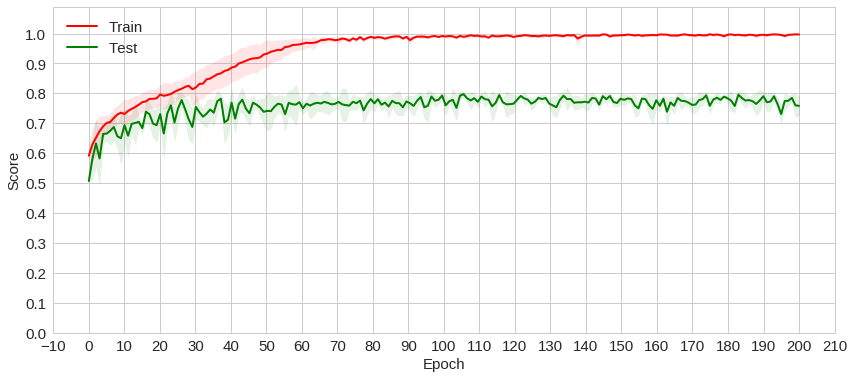

In [25]:
plot_mean_acc(history)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

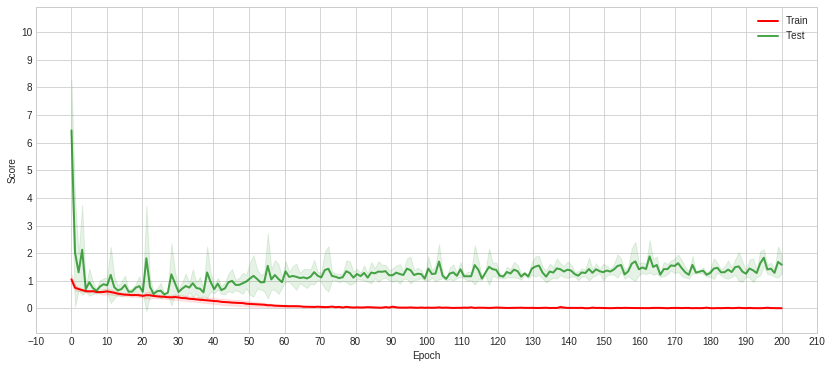

In [3]:
plot_mean_loss(history)